In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""

@author: yanchen
"""
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from random import sample,choice


import warnings
warnings.filterwarnings("ignore") # To ignore warnings

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

#from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support,classification_report


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
#from scipy import interp
import matplotlib.pyplot as plt
#from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
#from xgboost import XGBClassifier
from sklearn.preprocessing import scale
import matplotlib as mpl

from sklearn.preprocessing import MinMaxScaler, StandardScaler

#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
#from sklearn.metrics import make_scorer, roc_auc_score, recall_score, matthews_corrcoef, balanced_accuracy_score, accuracy_score, f1_score
#from sklearn.metrics import precision_score
#from sklearn.metrics import recall_score
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

In [3]:
### BUILD DATAFRAME OF EXTERNAL VARIABLES ###
def cycle_encode(data, cols, maxVal_cols = None):
    if maxVal_cols == None:
      #process training data
      maxVal_cols = []
      for i, col in enumerate(cols):
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        maxVal_cols.append(data[col].max())
    else:
      for i, col in enumerate(cols):
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/maxVal_cols[i])
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/maxVal_cols[i])
    return data, maxVal_cols

#drop columns that have more than missing_th missing data
def drop_cols_from_missing(df,cols,missing_th = 0.33):
  cols_drop_missing = [] #cols need to be dropped because too much missing data
  for col in cols:
    #print(col, ':', df_train[col].isna().sum()/len(df_train))
    if df[col][:int(len(df))].isna().sum()/int(len(df)) > missing_th: # more than missing_th nan
        df.drop(col, axis=1, inplace=True)
        print('drop col',col)
        cols_drop_missing.append(col)
  return df, cols_drop_missing

#since time series can't backward filled, remove rows that have leading missing values
def find_backward_missing(df,cols):
  for col in df.columns.difference(['Date','Close','Name']):
        df[col] = df[col].interpolate(method='linear', limit_direction='forward') # fill nans
  return df.isnull().any(axis=1)

def create_ext_feat(df, maxVal_cols = None):
  #if there is a 'Date' column
  #if index is DatetimeIndex
  if isinstance(df.index, pd.DatetimeIndex):
    df['year'] = df.index.year
    df['month'] = df.index.month
    #df['week'] = df.index.week
    df['week'] = df.index.isocalendar()['week']
  else:
    if 'date' in df.columns:
      df['year'] = df['Date'].dt.year
      df['month'] = df['Date'].dt.month
      df['week'] = df['Date'].dt.strftime('%V').astype('int')
      #set Date column as index
      df.set_index('Date', inplace=True)
  df, maxVal_cols = cycle_encode(df, ['year','month','week'], maxVal_cols)
  #print(maxVal_cols)
  df.drop(['year','month','week'], axis=1, inplace=True)
  return df, maxVal_cols

#create return column
def create_ret_col(df, level_col = None):
  df['ret'] = df[level_col].pct_change()*100
  df.dropna(inplace = True)
  return df

#create return label column
def create_label_col(df,n_class = 2):
  if n_class == 2:
    df['label'] = (df['ret'] > 0).astype(int)
  elif n_class == 3:
    df['label'] = pd.cut(x=df['ret'], bins=[df['ret'].min() - 1, -0.25,0.25,df['ret'].max() + 1],
                     labels=[0, 1, 2]) #0: sell, 1: neural, 2: buy
    df['label'] = df['label'].cat.codes  #convert categorical to numerical
  return df

In [4]:
#!/usr/bin/env python
# coding: utf-8

# # Scoring Rules

import numpy as np
import timeit

from scipy.stats import norm


# ## Interval Score


def interval_score(
    observations,
    alpha,
    q_dict=None,
    q_left=None,
    q_right=None,
    percent=False,
    check_consistency=True,
):
    """
    Compute interval scores (1) for an array of observations and predicted intervals.
    
    Either a dictionary with the respective (alpha/2) and (1-(alpha/2)) quantiles via q_dict needs to be
    specified or the quantiles need to be specified via q_left and q_right.
    
    Parameters
    ----------
    observations : array_like
        Ground truth observations.
    alpha : numeric
        Alpha level for (1-alpha) interval.
    q_dict : dict, optional
        Dictionary with predicted quantiles for all instances in `observations`.
    q_left : array_like, optional
        Predicted (alpha/2)-quantiles for all instances in `observations`.
    q_right : array_like, optional
        Predicted (1-(alpha/2))-quantiles for all instances in `observations`.
    percent: bool, optional
        If `True`, score is scaled by absolute value of observations to yield a percentage error. Default is `False`.
    check_consistency: bool, optional
        If `True`, quantiles in `q_dict` are checked for consistency. Default is `True`.
        
    Returns
    -------
    total : array_like
        Total interval scores.
    sharpness : array_like
        Sharpness component of interval scores.
    calibration : array_like
        Calibration component of interval scores.
        
    (1) Gneiting, T. and A. E. Raftery (2007). Strictly proper scoring rules, prediction, and estimation. Journal of the American Statistical Association 102(477), 359–378.    
    """

    if q_dict is None:
        if q_left is None or q_right is None:
            raise ValueError(
                "Either quantile dictionary or left and right quantile must be supplied."
            )
    else:
        if q_left is not None or q_right is not None:
            raise ValueError(
                "Either quantile dictionary OR left and right quantile must be supplied, not both."
            )
        q_left = q_dict.get(alpha / 2)
        if q_left is None:
            raise ValueError(f"Quantile dictionary does not include {alpha/2}-quantile")

        q_right = q_dict.get(1 - (alpha / 2))
        if q_right is None:
            raise ValueError(
                f"Quantile dictionary does not include {1-(alpha/2)}-quantile"
            )

    if check_consistency and np.any(q_left > q_right):
        raise ValueError("Left quantile must be smaller than right quantile.")

    sharpness = q_right - q_left
    calibration = (
        (
            np.clip(q_left - observations, a_min=0, a_max=None)
            + np.clip(observations - q_right, a_min=0, a_max=None)
        )
        * 2
        / alpha
    )
    if percent:
        sharpness = sharpness / np.abs(observations)
        calibration = calibration / np.abs(observations)
    total = sharpness + calibration
    return total, sharpness, calibration


# ## Weighted Interval Score


def weighted_interval_score(
    observations, alphas, q_dict, weights=None, percent=False, check_consistency=True
):
    """
    Compute weighted interval scores for an array of observations and a number of different predicted intervals.
    
    This function implements the WIS-score (2). A dictionary with the respective (alpha/2)
    and (1-(alpha/2)) quantiles for all alpha levels given in `alphas` needs to be specified.
    
    Parameters
    ----------
    observations : array_like
        Ground truth observations.
    alphas : iterable
        Alpha levels for (1-alpha) intervals.
    q_dict : dict
        Dictionary with predicted quantiles for all instances in `observations`.
    weights : iterable, optional
        Corresponding weights for each interval. If `None`, `weights` is set to `alphas`, yielding the WIS^alpha-score.
    percent: bool, optional
        If `True`, score is scaled by absolute value of observations to yield the double absolute percentage error. Default is `False`.
    check_consistency: bool, optional
        If `True`, quantiles in `q_dict` are checked for consistency. Default is `True`.
        
    Returns
    -------
    total : array_like
        Total weighted interval scores.
    sharpness : array_like
        Sharpness component of weighted interval scores.
    calibration : array_like
        Calibration component of weighted interval scores.
        
    (2) Bracher, J., Ray, E. L., Gneiting, T., & Reich, N. G. (2020). Evaluating epidemic forecasts in an interval format. arXiv preprint arXiv:2005.12881.
    """
    if weights is None:
        weights = np.array(alphas)/2

    def weigh_scores(tuple_in, weight):
        return tuple_in[0] * weight, tuple_in[1] * weight, tuple_in[2] * weight

    interval_scores = [
        i
        for i in zip(
            *[
                weigh_scores(
                    interval_score(
                        observations,
                        alpha,
                        q_dict=q_dict,
                        percent=percent,
                        check_consistency=check_consistency,
                    ),
                    weight,
                )
                for alpha, weight in zip(alphas, weights)
            ]
        )
    ]

    total = np.sum(np.vstack(interval_scores[0]), axis=0) / sum(weights)
    sharpness = np.sum(np.vstack(interval_scores[1]), axis=0) / sum(weights)
    calibration = np.sum(np.vstack(interval_scores[2]), axis=0) / sum(weights)

    return total, sharpness, calibration


def weighted_interval_score_fast(
    observations, alphas, q_dict, weights=None, percent=False, check_consistency=True
):
    """
    Compute weighted interval scores for an array of observations and a number of different predicted intervals.
    
    This function implements the WIS-score (2). A dictionary with the respective (alpha/2)
    and (1-(alpha/2)) quantiles for all alpha levels given in `alphas` needs to be specified.
    
    This is a more efficient implementation using array operations instead of repeated calls of `interval_score`.
    
    Parameters
    ----------
    observations : array_like
        Ground truth observations.
    alphas : iterable
        Alpha levels for (1-alpha) intervals.
    q_dict : dict
        Dictionary with predicted quantiles for all instances in `observations`.
    weights : iterable, optional
        Corresponding weights for each interval. If `None`, `weights` is set to `alphas`, yielding the WIS^alpha-score.
    percent: bool, optional
        If `True`, score is scaled by absolute value of observations to yield a percentage error. Default is `False`.
    check_consistency: bool, optional
        If `True`, quantiles in `q_dict` are checked for consistency. Default is `True`.
        
    Returns
    -------
    total : array_like
        Total weighted interval scores.
    sharpness : array_like
        Sharpness component of weighted interval scores.
    calibration : array_like
        Calibration component of weighted interval scores.
        
    (2) Bracher, J., Ray, E. L., Gneiting, T., & Reich, N. G. (2020). Evaluating epidemic forecasts in an interval format. arXiv preprint arXiv:2005.12881.
    """
    if weights is None:
        weights = np.array(alphas)/2

    if not all(alphas[i] <= alphas[i + 1] for i in range(len(alphas) - 1)):
        raise ValueError("Alpha values must be sorted in ascending order.")

    reversed_weights = list(reversed(weights))

    lower_quantiles = [q_dict.get(alpha / 2) for alpha in alphas]
    upper_quantiles = [q_dict.get(1 - (alpha / 2)) for alpha in reversed(alphas)]
    if any(q is None for q in lower_quantiles) or any(
        q is None for q in upper_quantiles
    ):
        raise ValueError(
            f"Quantile dictionary does not include all necessary quantiles."
        )

    lower_quantiles = np.vstack(lower_quantiles)
    upper_quantiles = np.vstack(upper_quantiles)

    # Check for consistency
    if check_consistency and np.any(
        np.diff(np.vstack((lower_quantiles, upper_quantiles)), axis=0) < 0
    ):
        raise ValueError("Quantiles are not consistent.")

    lower_q_alphas = (2 / np.array(alphas)).reshape((-1, 1))
    upper_q_alphas = (2 / np.array(list(reversed(alphas)))).reshape((-1, 1))

    # compute score components for all intervals
    sharpnesses = np.flip(upper_quantiles, axis=0) - lower_quantiles

    lower_calibrations = (
        np.clip(lower_quantiles - observations, a_min=0, a_max=None) * lower_q_alphas
    )
    upper_calibrations = (
        np.clip(observations - upper_quantiles, a_min=0, a_max=None) * upper_q_alphas
    )
    calibrations = lower_calibrations + np.flip(upper_calibrations, axis=0)

    # scale to percentage absolute error
    if percent:
        sharpnesses = sharpnesses / np.abs(observations)
        calibrations = calibrations / np.abs(observations)

    totals = sharpnesses + calibrations

    # weigh scores
    weights = np.array(weights).reshape((-1, 1))

    sharpnesses_weighted = sharpnesses * weights
    calibrations_weighted = calibrations * weights
    totals_weighted = totals * weights

    # normalize and aggregate all interval scores
    weights_sum = np.sum(weights)

    sharpnesses_final = np.sum(sharpnesses_weighted, axis=0) / weights_sum
    calibrations_final = np.sum(calibrations_weighted, axis=0) / weights_sum
    totals_final = np.sum(totals_weighted, axis=0) / weights_sum

    return totals_final, sharpnesses_final, calibrations_final


# ## Outside-Interval Count


def outside_interval(observations, lower, upper, check_consistency=True):
    """
    Indicate whether observations are outside a predicted interval for an array of observations and predicted intervals.
    
    Parameters
    ----------
    observations : array_like
        Ground truth observations.
    lower : array_like, optional
        Predicted lower interval boundary for all instances in `observations`.
    upper : array_like, optional
        Predicted upper interval boundary for all instances in `observations`.
    check_consistency: bool, optional
        If `True`, interval boundaries are checked for consistency. Default is `True`.
        
    Returns
    -------
    Out : array_like
        Array of zeroes (False) and ones (True) counting the number of times observations where outside the interval.
    """
    if check_consistency and np.any(lower > upper):
        raise ValueError("Lower border must be smaller than upper border.")

    return ((lower > observations) + (upper < observations)).astype(int)


# ## Interval Consistency Score


def interval_consistency_score(
    lower_old, upper_old, lower_new, upper_new, check_consistency=True
):
    """
    Compute interval consistency scores for an old and a new interval.
    
    Adapted variant of the interval score which measures the consistency of updated intervals over time.
    Ideally, updated predicted intervals would always be within the previous estimates of the interval, yielding
    a score of zero (best).
    
    Parameters
    ----------
    lower_old : array_like
        Previous lower interval boundary for all instances in `observations`.
    upper_old : array_like, optional
        Previous upper interval boundary for all instances in `observations`.
    lower_new : array_like
        New lower interval boundary for all instances in `observations`. Ideally higher than the previous boundary.
    upper_new : array_like, optional
        New upper interval boundary for all instances in `observations`. Ideally lower than the previous boundary.
    check_consistency: bool, optional
        If interval boundaries are checked for consistency. Default is `True`.
        
    Returns
    -------
    scores : array_like
        Interval consistency scores.
    """
    if check_consistency and (
        np.any(lower_old > upper_old) or np.any(lower_new > upper_new)
    ):
        raise ValueError("Left quantile must be smaller than right quantile.")

    scores = np.clip(lower_old - lower_new, a_min=0, a_max=None) + np.clip(
        upper_new - upper_old, a_min=0, a_max=None
    )
    return scores


# ## MAE


def mae_score(observations, point_forecasts):
    return np.abs(observations - point_forecasts).mean(1)


# ## MAPE and sMAPE


def mape_score(observations, point_forecasts):
    return 100 * np.abs(point_forecasts - observations) / np.abs(observations)


def smape_score(observations, point_forecasts):
    return 100 * (
        2
        * np.abs(point_forecasts - observations)
        / (np.abs(observations) + np.abs(point_forecasts))
    )


# ## MASE


def mase_score(observations, point_forecasts, horizon):
    mae_naive = mae_score(observations[:, horizon:], observations[:, 0:-horizon])
    mae_pred = mae_score(observations, point_forecasts)
    return mae_pred / mae_naive

In [5]:
#Convert to supervised learning format, X lag 1
def split_sequence_enc_dec(sequence, cols_feat, cols_target, look_back, forecast_horizon):
 X, y = list(), list()
 for i in range(len(sequence)):
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x = sequence[cols_feat].iloc[i:lag_end]
   seq_y = sequence[cols_target].iloc[lag_end:forecast_end]
   arr_x = np.array(seq_x).flatten()
   arr_y = np.array(seq_y).flatten()
   X.append(arr_x)
   y.append(arr_y)
 return np.array(X), np.array(y)
 #return X, y

In [6]:
##Convert to supervised learning format, X lag 1
def split_sequence(sequence, look_back, forecast_horizon):
 X, y = list(), list()
 for i in range(len(sequence)):
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
   X.append(seq_x)
   y.append(seq_y)
 return np.array(X), np.array(y)

In [7]:
def split_sequence_enc_dec2(sequence, cols_enc, cols_dec, cols_target, look_back, forecast_horizon):
 X_enc, X_dec, y = list(), list(), list()
 #cols_enc = list(set(list(cols_feat) + list(cols_target)))
 #cols_dec = cols_feat.difference(cols_target) #if target is in features, can't use its current value
 for i in range(len(sequence)): 
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x_enc = sequence[cols_enc].iloc[i:lag_end]
   seq_x_dec= sequence[cols_dec].iloc[forecast_end-look_back:forecast_end]
   seq_y = sequence[cols_target].iloc[lag_end:forecast_end]
   X_enc.append(seq_x_enc)
   X_dec.append(seq_x_dec)
   y.append(seq_y)
 return np.array(X_enc), np.array(X_dec), np.array(y)

In [8]:
def split_sequence_enc_dec_log_diff(sequence, cols_enc, cols_dec, cols_target, cols_target_log_diff, look_back, forecast_horizon):
 X_enc, X_dec, y, y_log_diff = list(), list(), list(), list()
 #cols_enc = list(set(list(cols_feat) + list(cols_target)))
 #cols_dec = cols_feat.difference(cols_target) #if target is in features, can't use its current value
 for i in range(len(sequence)): 
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x_enc = sequence[cols_enc].iloc[i:lag_end]
   seq_x_dec= sequence[cols_dec].iloc[forecast_end-look_back:forecast_end]
   seq_y = sequence[cols_target].iloc[lag_end:forecast_end]
   seq_y_log_diff = sequence[cols_target_log_diff].iloc[lag_end:forecast_end]
   X_enc.append(seq_x_enc)
   X_dec.append(seq_x_dec)
   y.append(seq_y)
   y_log_diff.append(seq_y_log_diff)
 return np.array(X_enc), np.array(X_dec), np.array(y), np.array(y_log_diff)

In [9]:
#Some constants
missing_th = 0.33
LOOK_BACK = 16
FORECAST_RANGE = 8
IS_ABSEN = True
IS_PCA = False
EXT = True#create external features
date_cols = ['year_cos','year_sin','month_cos','month_sin','week_cos','week_sin']
SEED = 2024
is_plot_total = True
sample_weight_mode = 'bin'
model_type = 'rf'
y_convert_mode = None

In [10]:
from sklearn.preprocessing import FunctionTransformer
log1p_transformer = FunctionTransformer(np.log1p,inverse_func = np.expm1)

ss_transformer = StandardScaler()

In [11]:
def create_rolling_train_test_data(df_full, train_start_date_dt, 
                                   train_end_date_dt, test_start_date_dt, 
                                   test_end_date_dt, FORECAST_RANGE = 1, 
                                   n_components = 30,y_col = 'all_flu_case',
                                     col_date = 'date', date_cols = date_cols,
                                     y_convert_mode = None):
  if EXT:
    df_rolling = df_full[df_full.columns.difference(['monthid','weekid','uid',col_date])]
  else:
    df_rolling = df_full[df_full.columns.difference(['uid',col_date])]
  df_rolling.index = pd.to_datetime(df_full[col_date])
  df_train = df_rolling[(df_rolling.index >= train_start_date_dt) & (df_rolling.index <= train_end_date_dt)]
  df_test = df_rolling[(df_rolling.index >= test_start_date_dt) & (df_rolling.index <= test_end_date_dt)]
  if EXT:
    df_train, maxVal_cols = create_ext_feat(df_train)
    df_test, maxVal_cols = create_ext_feat(df_test,maxVal_cols)
  n_test = len(df_test)
  n_window = len(df_train)
  #df_train = df_full.iloc[end_test_row-n_test-n_window:end_test_row-n_test]
  #df_test = df_full.iloc[end_test_row-n_test:end_test_row]
  df_tmp = pd.concat([df_train,df_test],axis = 0)
  ### Scaling and PCA
  x_scaler = StandardScaler()
  #x_scaler = RobustScaler()
  df_train_X = df_train[df_train.columns.difference([y_col,'region'])]
  df_train_X_scaled = pd.DataFrame(x_scaler.fit_transform(df_train_X), columns = df_train.columns.difference([y_col,'region']), index = df_train.index)

  df_test_X = df_test[df_test.columns.difference([y_col,'region'])]
  df_test_X_scaled = pd.DataFrame(x_scaler.transform(df_test_X), columns = df_test.columns.difference([y_col,'region']), index = df_test.index)
  if IS_PCA:
    adj_n_components = min(df_train_X_scaled.shape[0], df_train_X_scaled.shape[1],n_components)
    print('adj_n_components',adj_n_components)
    pca = PCA(n_components=adj_n_components, random_state = 0)
    arr_train_X_scaled_pca = pca.fit_transform(df_train_X_scaled)
    print('explained_variance_','{:.2f}'.format(np.sum(pca.explained_variance_)))
    df_train_pca = pd.DataFrame(arr_train_X_scaled_pca,index=df_train.index, columns = ['p'+str(i) for i in range(adj_n_components)])
    df_train_pca[[y_col]] = df_train[[y_col]]

    arr_test_X_scaled_pca = pca.transform(df_test_X_scaled)
    df_test_pca = pd.DataFrame(arr_test_X_scaled_pca,index=df_test.index, columns = ['p'+str(i) for i in range(adj_n_components)])
    df_test_pca[[y_col]] = df_test[[y_col]]
    df_pca = pd.concat([df_train_pca,df_test_pca],axis = 0)
  
  else:
    df_train_X_scaled[[y_col]] = df_train[[y_col]]
    df_test_X_scaled[[y_col]] = df_test[[y_col]]
    df_pca = pd.concat([df_train_X_scaled,df_test_X_scaled],axis = 0)
  
  
  
  #cols_feat = df_pca.columns.difference(['region']) #including lagged target itself as features
  known_cols = date_cols + col_temp
  cols_target = [y_col]
  #df_pca[cols_target]=df_pca[cols_target].diff(8) #deduct the value of 8 weeks ago, train on residual
  #df_pca.dropna()
  if y_convert_mode == 'log_diff':
    df_pca[f'{y_col}_t_1'] = df_pca[y_col].shift(1)
    df_pca = df_pca.iloc[1:,:]
    df_pca[f'{y_col}_log_diff'] = np.log(df_pca[y_col]/df_pca[f'{y_col}_t_1'])
    cols_target_log_diff = [f'{y_col}_log_diff']
    unknown_cols = x_cols_unknown + [f'{y_col}_log_diff']
    X_enc, X_dec, Y, Y_log_diff = split_sequence_enc_dec_log_diff(df_pca, unknown_cols, known_cols, cols_target,cols_target_log_diff, look_back = LOOK_BACK, forecast_horizon = FORECAST_RANGE)
  else:
    
    unknown_cols = x_cols_unknown + [y_col]
    X_enc, X_dec, Y = split_sequence_enc_dec2(df_pca, unknown_cols, known_cols, cols_target, look_back = LOOK_BACK, forecast_horizon = FORECAST_RANGE)

  
  if y_convert_mode == 'deduct_8':
    """
    shape0,shape1 = X_enc.shape
    tmp_X = X_enc[:,:,-1].reshape(shape0,shape1,1)
    Y_8w_diff = Y - tmp_X
    """
    Y=pd.DataFrame(Y.squeeze()).diff(8).dropna()
    Y = Y.to_numpy().reshape(Y.shape[0],Y.shape[1],1)
    X = X[8:,...]
  
  
  X = np.concatenate((X_enc,X_dec),axis = 2)
  
  
  print('X.shape before squeeze',X.shape)
  X_before = X.copy()
  X = X.reshape((*X.shape[:-2], -1))
  print('X.shape after squeeze',X.shape)

  X_date, Y_date = split_sequence(df_pca.index, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
  Y_train_date,Y_test_date = Y_date[-n_test-n_window:-n_test], Y_date[-n_test:]


  if y_convert_mode == 'log_diff':
    X_train,Y_train= X[-n_test-n_window:-n_test,:], Y_log_diff[-n_test-n_window:-n_test,:]
    X_test,Y_test, Y_test_origin_scale,Y_test_last = X[-n_test:,:], Y_log_diff[-n_test:,:], Y[-n_test:,:], Y[-n_test-1,:]
  elif y_convert_mode == 'deduct_8':
    X_train,Y_train = X[-n_test-n_window:-n_test,:], Y_8w_diff[-n_test-n_window:-n_test,:]
    X_test,Y_test,Y_test_last = X[-n_test:,:], Y_8w_diff[-n_test:,:], Y[-n_test-1,:]
  else:
    X_train,Y_train = X[-n_test-n_window:-n_test,:], Y[-n_test-n_window:-n_test,:]
    X_test,Y_test,Y_test_last = X[-n_test:,:], Y[-n_test:,:], Y[-n_test-1,:]
    

  Y_train = Y_train.squeeze()
  if y_convert_mode == 'log':
    Y_train = log1p_transformer.transform(Y_train)
  elif y_convert_mode == 'stand':
    Y_train = ss_transformer.fit_transform(Y_train)
  Y_test = Y_test.squeeze() #randomregressor can only accept 2d data, not 3d
  if y_convert_mode == 'log_diff':
    Y_test = Y_test_origin_scale
  if len(Y_train.shape)==1:
    Y_train=Y_train.reshape(-1,1)
    Y_test = Y_test.reshape(-1,1)
  
  return X_train,Y_train,X_test,Y_test, Y_test_last, Y_train_date, Y_test_date,df_train_X_scaled,df_test_X_scaled,X_before

In [12]:
import os
import platform
#os.chdir('/Users/yanchen/Dropbox/hksph/hksph-project')
pwd=os.path.abspath(os.path.dirname(os.getcwd()))
if platform.system()=='Windows':
    path = pwd + r'\flu_data\hk_data_org.csv'
else:
    path = pwd + '/flu_data/hk_data_org.csv'

path = '/Users/yanchen/Dropbox/hksph/hksph-project/flu_data/hk_data_org.csv'
#os.chdir('/Users/yanchen/Documents/flu_data')
#file_name = 'hk_data_org.csv'
df_raw=pd.read_csv(path)
#df_raw['date'] = pd.to_datetime(df_raw['date'] , format = '%Y-%m-%d')
#replace dot with underscore
df_raw.columns = [c.replace('.', '_') for c in df_raw.columns]
#df_raw.head()

In [13]:
"""
if platform.system()=='Windows':
    path = pwd + '\\flu_data\\ts_week.csv'
else:
    path = pwd + '/flu_data/ts_week.csv'
"""
path = '/Users/yanchen/Dropbox/hksph/hksph-project/flu_data/ts_week.csv'
df_absence=pd.read_csv(path,index_col=0)

#replace dot with underscore
df_absence.columns = [c.replace('.', '_') for c in df_absence.columns]
df_absence.head()

df_merged = df_raw.merge(df_absence[['date', 'absent_proportion']], on = 'date', how = 'left')

In [14]:
col_pos_rates = ['h1_pos', 'sh3_pos','b_pos', 'Adenovirus', 'paraflu12', 'paraflu34', 'RSV']
cols_pos_cases = [col + '_case' for col in col_pos_rates]
if IS_ABSEN:
    df_raw_adj = df_merged.loc[df_merged['date']>='2008-09-07',]
else:
    #df_raw_adj = df_raw.copy() 
    df_raw_adj = df_raw.loc[df_raw['date']>='2008-09-07',]
for col in col_pos_rates:
    df_raw_adj[col + '_case'] = df_raw_adj[col]*df_raw_adj["rate_All"]
#df_raw['all_flu'] = df_raw['h1_pos'] + df_raw['sh3_pos'] + df_raw['b_pos']
df_raw_adj.drop(col_pos_rates + ['rate_All'], axis=1,inplace= True)
df_raw_adj.head()

,region,uid,date,weekid,temp_max,temp_mean,temp_min,relative_humidity,total_rainfall,solar_radiation,...,temp_range,monthid,absent_proportion,h1_pos_case,sh3_pos_case,b_pos_case,Adenovirus_case,paraflu12_case,paraflu34_case,RSV_case
218,HK,2008-36,2008-09-07,36,32.4,28.185714,27.7,81.428571,7.621429,14.931429,...,4.842857,9,1.2,0.768145,2.765320,0.409677,1.382660,0.153629,0.307258,3.738304
219,HK,2008-37,2008-09-14,37,34.2,29.600000,28.4,68.571429,0.035714,21.267143,...,5.057143,9,1.5,0.742887,1.609588,0.330172,0.701615,0.206357,0.660344,3.631890
220,HK,2008-38,2008-09-21,38,33.8,29.757143,29.0,74.571429,3.585714,15.581429,...,4.828571,9,1.6,0.981162,1.407754,0.213296,0.725207,0.127978,0.298615,2.559554
221,HK,2008-39,2008-09-28,39,34.3,28.671429,28.3,77.142857,11.521429,14.671429,...,5.628571,9,3.2,0.293523,0.929489,0.293523,1.223012,0.440284,0.440284,2.250343
222,HK,2008-40,2008-10-05,40,31.8,27.014286,25.5,75.857143,20.285714,13.350000,...,5.100000,10,2.2,0.255055,0.969209,0.000000,0.714154,0.102022,0.918198,3.417738


In [15]:
col_date = 'date'
df_raw_adj[col_date] = pd.to_datetime(df_raw_adj[col_date] , format = '%Y-%m-%d')
min_date = df_raw_adj[col_date].min()
max_date = df_raw_adj[col_date].max()
print(min_date)
print(max_date)

col_region = 'region'
ls_regions = df_raw_adj[col_region].unique()
print(df_raw_adj[col_region].unique())
print(df_raw_adj[col_region].unique().shape)

df_raw_adj['all_flu_case'] = df_raw_adj['h1_pos_case'] + df_raw_adj['sh3_pos_case'] + df_raw_adj['b_pos_case']
#df_raw.drop(['h1_pos_case', 'sh3_pos_case','b_pos_case'], axis=1,inplace = True)

col_value = ['region','all_flu_case','h1_pos_case','sh3_pos_case','b_pos_case','Adenovirus_case','paraflu12_case','paraflu34_case', 'RSV_case']
col_value_noregion = ['all_flu_case','h1_pos_case','sh3_pos_case','b_pos_case','Adenovirus_case', 'paraflu12_case','paraflu34_case', 'RSV_case']

#df_raw['all_flu'] = df_raw['h1_pos'] + df_raw['sh3_pos'] + df_raw['b_pos']
#df_raw.drop(['h1_pos', 'sh3_pos','b_pos'], axis=1)

#col_value = ['region','rate_All', 'Adenovirus', 'paraflu12', 'paraflu34', 'RSV','all_flu']
#col_value_noregion = ['rate_All', 'Adenovirus', 'paraflu12', 'paraflu34', 'RSV','all_flu']

if IS_ABSEN:
#fill with 95% percentile
    df_raw_adj['absent_proportion'] = df_raw_adj['absent_proportion'].fillna(7.085)

2008-09-07 00:00:00
2019-12-29 00:00:00
['HK']
(1,)


In [16]:
remove_start_date = '2009-04-01'
#remove_start_date_dt = datetime.strptime(test_start_date, '%Y-%m-%d')
remove_end_date = '2010-03-31'
#remove_end_date_dt = datetime.strptime(test_start_date, '%Y-%m-%d')
print(df_raw_adj.shape)
#df_raw_adj3 = copy.deepcopy(df_raw_adj)
df_raw_adj =df_raw_adj.loc[~((df_raw_adj.date >= remove_start_date)&(df_raw_adj.date <= remove_end_date)),:]
#df_raw_adj =df_raw_adj.loc[(df_raw_adj.date > remove_end_date_dt),:]
print(df_raw_adj.shape)

(591, 24)
(539, 24)


In [17]:
y_col = 'all_flu_case'
#x_cols = [col for col in col_value_noregion if col != y_col]
x_cols = [col for col in df_raw_adj.columns.difference(['weekid','monthid','uid',col_date,col_region]) if col != y_col]
print(x_cols)
location_col = 'region'
targets = [y_col]

col_temp = [x for x in x_cols if x not in col_value_noregion]
x_cols_unknown = [x for x in x_cols if x not in col_temp]

['Adenovirus_case', 'RSV_case', 'absent_proportion', 'absolute_humidity', 'b_pos_case', 'h1_pos_case', 'paraflu12_case', 'paraflu34_case', 'pressure', 'relative_humidity', 'sh3_pos_case', 'solar_radiation', 'temp_max', 'temp_mean', 'temp_min', 'temp_range', 'total_rainfall', 'wind_speed']


In [18]:
from pandas import DataFrame, to_datetime, to_timedelta
from datetime import datetime

val_size = 365
test_size = 365
train_size = 2555

test_start_date0 = '2013-11-01'
test_start_date0_dt = datetime.strptime(test_start_date0, '%Y-%m-%d')





#The peak flu season in Hong Kong generally occurs between January and March, and again from July to August.

test_start_date = '2013-11-01' # 2002-10-01 is the earliest test start date for US state data
test_start_date_dt = datetime.strptime(test_start_date, '%Y-%m-%d')
test_end_date_dt = min(test_start_date_dt + to_timedelta(test_size, unit='day'),max_date)
#val_start_date_dt = max(test_start_date_dt - to_timedelta(val_size, unit='day'),min_date + to_timedelta(100, unit='day'))

#train_end_date_dt = val_start_date_dt - to_timedelta(1, unit='day')
train_end_date_dt = test_start_date_dt - to_timedelta(1, unit='W')
#train_start_date_dt = max(train_end_date_dt - to_timedelta(train_size, unit='day'),min_date)
train_start_date_dt = min_date
print('train_start_date_dt',train_start_date_dt)
print('train_end_date_dt',train_end_date_dt)
print('test_start_date_dt',test_start_date_dt)


train_start_date_dt 2008-09-07 00:00:00
train_end_date_dt 2013-10-25 00:00:00
test_start_date_dt 2013-11-01 00:00:00


In [19]:
hparam_dict = {}
#hparam_dict['n_estimators'] = 40
hparam_dict['n_estimators'] = 80
hparam_dict['max_features'] = 200#190 if no absence data included
hparam_dict['max_depth'] = 20
hparam_dict['min_samples_split'] =10
hparam_dict['min_samples_leaf']=8
hparam_dict['criterion']='absolute_error'
hparam_dict['bootstrap'] = True
hparam_dict['train_start_fix']=1

In [20]:
if EXT:
    X_train,Y_train,X_test,Y_test, Y_test_last, Y_train_date, Y_test_date,df_train,df_test,X_before= create_rolling_train_test_data(df_raw_adj, train_start_date_dt,train_end_date_dt, test_start_date_dt, test_end_date_dt, FORECAST_RANGE = FORECAST_RANGE, n_components = 30,y_col = y_col,y_convert_mode= None)
else:
    X_train,Y_train,X_test,Y_test, Y_test_last, Y_train_date, Y_test_date,df_train,df_test,X_before= create_rolling_train_test_data(df_raw_adj, train_start_date_dt,train_end_date_dt, test_start_date_dt, test_end_date_dt, FORECAST_RANGE = FORECAST_RANGE, n_components = 30,y_col = y_col,date_cols = ['monthid','weekid'],y_convert_mode= None)
print(np.std(Y_train.flatten()))
print(X_train.shape)
print(Y_train.shape)

X.shape before squeeze (245, 16, 25)
X.shape after squeeze (245, 400)
5.380853783967921
(193, 400)
(193, 8)


In [21]:
import scipy.stats
my_normal = scipy.stats.norm(np.mean(Y_train.flatten()), np.std(Y_train.flatten()))

In [22]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, shuffle=False, train_size=0.8)
print(y_train.shape)
y_train.squeeze().shape

(154, 8)


(154, 8)

In [23]:
np.sum(pd.DataFrame(x_train).isna().sum())


0

In [24]:
unknown_cols = x_cols_unknown + [y_col]
if EXT:
    known_cols = date_cols + col_temp
else:
    known_cols = ['monthid','weekid'] + col_temp

feat_names = list(unknown_cols + known_cols)

In [25]:
## train model in a rolling manner
list_alpha = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.98]
def my_rolling_train(df_full,FORECAST_RANGE = FORECAST_RANGE, y_col = y_col,hparam_dict = None, 
                     seed = SEED,sample_weight_mode = 'bin',
                     alphas = list_alpha,y_convert_mode = None):
  #n_round: number of rolling windows
  ls_y_test_pred = []
  ls_y_train_pred = []
  ls_Y_train_pred = []
  ls_y_val_pred = []

  ls_Y_test_date = []
  ls_Y_test = []
  ls_Y_test_last = []
  ls_Y_train = []
  ls_Y_train_date = []
  ls_y_train = []

  ls_importance = []
  ls_importance_std = []
  ls_feat_shuffle = []


  #ls_lowt = []
  #ls_higt  = []
  #ls_cover = []
  
  ls_q_forecsts = []

  #mix_scoring = {'f1_macro':'f1_macro'}
  refit_scorer ="neg_mean_squared_error"

  if hparam_dict['bootstrap']:
    is_oob_score = True
  else:
    is_oob_score = False
  rf = RandomForestRegressor(n_estimators = hparam_dict['n_estimators'], 
                             min_samples_split = hparam_dict['min_samples_split'],
                           min_samples_leaf = hparam_dict['min_samples_leaf'], 
                           max_features = hparam_dict['max_features'],max_depth = hparam_dict['max_depth'],
                           criterion = hparam_dict['criterion'],
                           bootstrap = hparam_dict['bootstrap'],
                           oob_score= is_oob_score,
                           random_state = random.seed(seed))
  
  for iteration in range(6):
    #count +=1
    print('iteration',  iteration)
    test_start_date_dt = min(test_start_date0_dt + to_timedelta(365*iteration, unit='day'),max_date)
    #test_start_date = '2012-01-01'
    #test_start_date_dt = datetime.strptime(test_start_date, '%Y-%m-%d')
    test_end_date_dt = min(test_start_date_dt + to_timedelta(test_size, unit='day'),max_date)
    #train_end_date_dt = test_start_date_dt - to_timedelta(8, unit='W')
    train_end_date_dt = test_start_date_dt - to_timedelta(1, unit='W')
    if hparam_dict['train_start_fix']==1:
      train_start_date_dt = min_date
    else:
      train_start_date_dt = max(train_end_date_dt - to_timedelta(train_size, unit='day'),min_date)
    
    print('train_end_date_dt',  train_end_date_dt)
    print('test_start_date_dt',  test_start_date_dt)
    if EXT:
      X_train,Y_train,X_test,Y_test, Y_test_last, Y_train_date, Y_test_date,df_train,df_test,X_before = create_rolling_train_test_data(df_full, 
                                                                                                  train_start_date_dt,train_end_date_dt, test_start_date_dt, test_end_date_dt
                                                                                                  , FORECAST_RANGE = FORECAST_RANGE, n_components = 30,y_col = y_col,
                                                                                                  y_convert_mode= y_convert_mode)
    else:
      X_train,Y_train,X_test,Y_test, Y_test_last, Y_train_date, Y_test_date,df_train,df_test,X_before = create_rolling_train_test_data(df_full, 
                                                                                                  train_start_date_dt,train_end_date_dt, test_start_date_dt, test_end_date_dt
                                                                                                  , FORECAST_RANGE = FORECAST_RANGE, n_components = 30,y_col = y_col,
                                                                                                  date_cols = ['monthid','weekid'],
                                                                                                  y_convert_mode= y_convert_mode)
    print('number of features',X_train.shape[1])
    ls_Y_test_date.append(Y_test_date)
    ls_Y_test.append(Y_test)
    ls_Y_test_last.append(Y_test_last)

    ls_Y_train_date.append(Y_train_date)
    ls_Y_train.append(Y_train)

    x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, shuffle=False, train_size=0.8)
    ls_y_train.append(y_train)
    #use unscaled data
    rf_best = rf

    if sample_weight_mode == 'bin':
      #tmp = y_train.squeeze()
      tmp = np.max(y_train, axis = 1)
      my_bins = np.percentile(tmp,q = [35,75])
      tmp_cate = np.digitize(tmp,bins = my_bins)
      my_dict = {0:0.25,1:0.25,2:0.5}
      my_sample_weight = np.vectorize(my_dict.get)(tmp_cate)
    elif sample_weight_mode == 'exp':
      my_sample_weight = np.exp(-10*my_normal.pdf(np.mean(y_train,axis = 1)))
    elif sample_weight_mode == 'pow':
      raw_weights = my_normal.pdf(np.mean(y_train,axis = 1))
      my_sample_weight = 1/(np.power(raw_weights,0.1)+1e-10)
    else:
      my_sample_weight = np.ones(y_train.squeeze().shape[0])

    rf_best.fit(x_train, y_train,sample_weight  = my_sample_weight)
    
    
    importances = rf_best.feature_importances_
    std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
    ls_importance.append(importances)
    ls_importance_std.append(std)
    

    Y_train_pred = rf_best.predict(X_train) #include validation
    ls_Y_train_pred.append(Y_train_pred)
    y_train_pred = rf_best.oob_prediction_ #exclude validation
    ls_y_train_pred.append(y_train_pred)
    y_val_pred = rf_best.predict(x_val)
    ls_y_val_pred.append(y_val_pred)
    

    y_test_pred = rf_best.predict(X_test)
    ls_y_test_pred.append(y_test_pred)
    
    if is_oob_score:
      q_dict = {}
    # Generating the error distribution
      if y_train.shape[1]==1:
        resid = y_train - y_train_pred.reshape(-1,1)
      else:
        resid = y_train - y_train_pred
      
      for alpha in alphas:
        lowq = pd.DataFrame(resid).quantile(alpha/2)
        higq = pd.DataFrame(resid).quantile(1-alpha/2)
        
        lowt = (y_test_pred + lowq.values)
        higt = (y_test_pred + higq.values)

        q_dict[alpha/2]=lowt
        q_dict[1-alpha/2]=higt

      ls_q_forecsts.append(q_dict)
      
  ##feature importance
    # COMPUTE BASELINE (NO SHUFFLE)
    feat_imp = []
    if Y_train.shape[1]==1:
      baseline_mae = np.mean(np.abs(Y_train_pred-Y_train.squeeze()))
    else:
       baseline_mae = np.mean(np.abs(Y_train_pred-Y_train.squeeze()))
    feat_imp.append({'feature':'BASELINE','mae':baseline_mae})           

    for fi in range(len(feat_names)):
        for l in range(LOOK_BACK):
                k = fi*LOOK_BACK + l
                # SHUFFLE FEATURE K
                save_col = X_train[:,k].copy()
                np.random.shuffle(X_train[:,k])
                        
                # COMPUTE OOF MAE WITH FEATURE K SHUFFLED
                oof_preds = rf_best.predict(X_train).squeeze() 
                mae = np.mean(np.abs(oof_preds-Y_train.squeeze()))
                feat_imp.append({'feature':feat_names[fi]+'-lag-'+str(l),'mae':mae})
                X_train[:,k] = save_col
    ls_feat_shuffle.append(feat_imp) 
    
  return ls_q_forecsts,rf_best,ls_Y_train_pred,ls_y_train_pred,ls_y_val_pred,ls_y_test_pred,ls_Y_train, ls_y_train,ls_Y_test,ls_Y_test_last,ls_Y_train_date, ls_Y_test_date, ls_importance, ls_importance_std, ls_feat_shuffle

In [26]:
#ls_model_history,ls_y_test_pred,ls_Y_test,ls_Y_test_date = my_rolling_train(df_full,n_test = 200, n_round = 1, FORECAST_RANGE = FORECAST_RANGE, n_window = 1000,y_col = y_col, random_grid = random_grid)ls_lowt,ls_higt,ls_cover,rf_best,

ls_q_forecasts,rf_best,ls_Y_train_pred,ls_y_train_pred,ls_y_val_pred,ls_y_test_pred,ls_Y_train, ls_y_train, ls_Y_test,ls_Y_test_last,ls_Y_train_date, ls_Y_test_date, ls_importance, ls_importance_std,ls_feat_shuffle = my_rolling_train(df_raw_adj, FORECAST_RANGE = FORECAST_RANGE, y_col = y_col
                                                                                                                                                                                         ,hparam_dict = hparam_dict, seed = SEED, 
                                                                                                                                                                                         sample_weight_mode= sample_weight_mode,
                                                                                                                                                                                         y_convert_mode = y_convert_mode)

iteration 0
train_end_date_dt 2013-10-25 00:00:00
test_start_date_dt 2013-11-01 00:00:00
X.shape before squeeze (245, 16, 25)
X.shape after squeeze (245, 400)
number of features 400
iteration 1
train_end_date_dt 2014-10-25 00:00:00
test_start_date_dt 2014-11-01 00:00:00
X.shape before squeeze (298, 16, 25)
X.shape after squeeze (298, 400)
number of features 400
iteration 2
train_end_date_dt 2015-10-25 00:00:00
test_start_date_dt 2015-11-01 00:00:00
X.shape before squeeze (351, 16, 25)
X.shape after squeeze (351, 400)
number of features 400
iteration 3
train_end_date_dt 2016-10-24 00:00:00
test_start_date_dt 2016-10-31 00:00:00
X.shape before squeeze (402, 16, 25)
X.shape after squeeze (402, 400)
number of features 400
iteration 4
train_end_date_dt 2017-10-24 00:00:00
test_start_date_dt 2017-10-31 00:00:00
X.shape before squeeze (454, 16, 25)
X.shape after squeeze (454, 400)
number of features 400
iteration 5
train_end_date_dt 2018-10-24 00:00:00
test_start_date_dt 2018-10-31 00:00:00
X

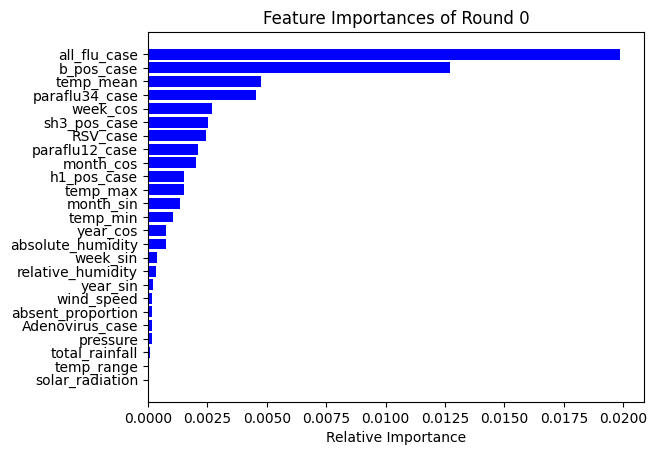

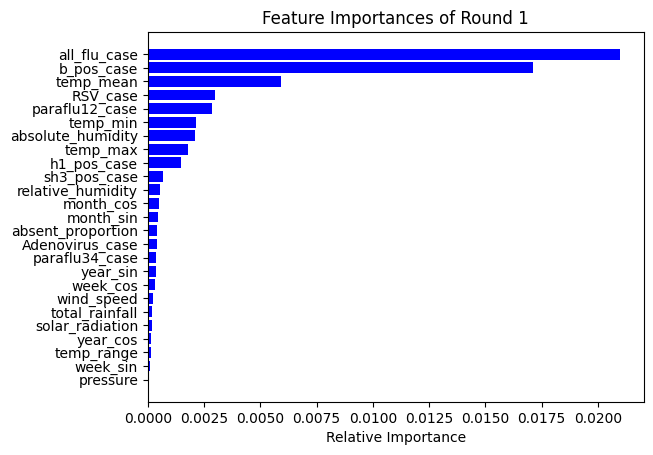

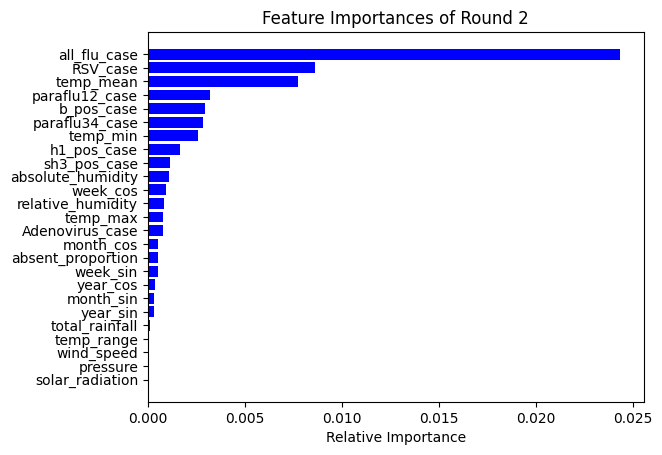

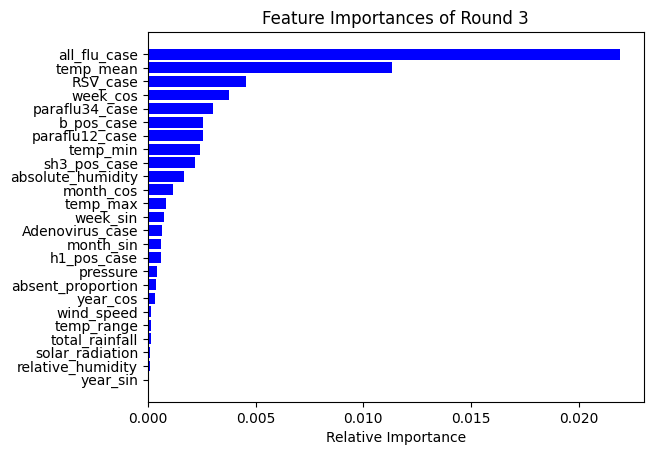

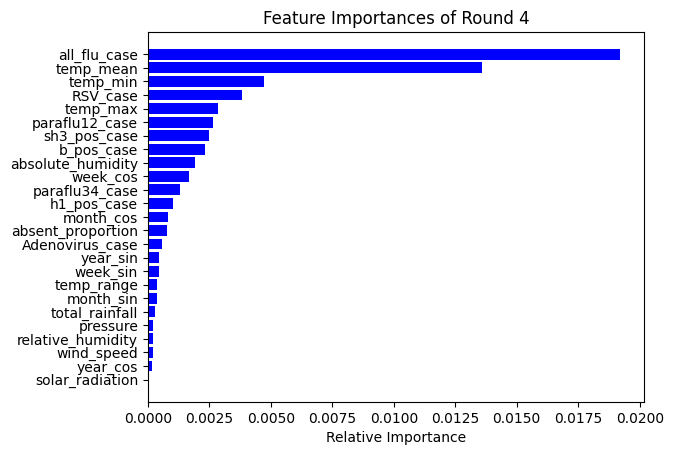

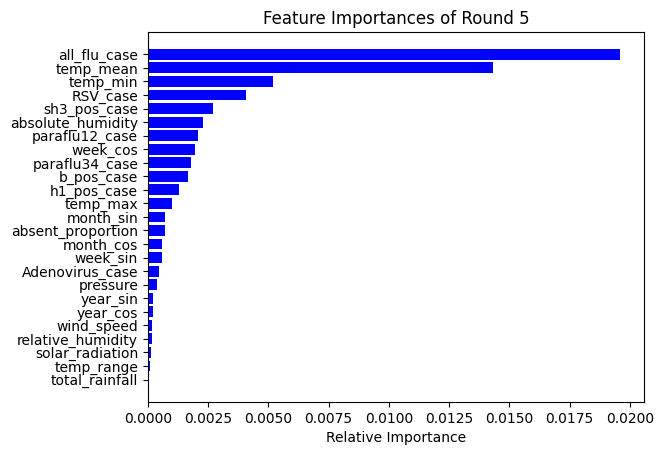

In [27]:
ls_avg_importances = []
ls_absent_importances = [] #14th feature
ls_lag_y_importances = [] #7th feature

for round in range(6):
    arr_importance = ls_importance[round].reshape(LOOK_BACK,-1)
    avg_importances = np.mean(arr_importance,axis = 0)
    indices = np.argsort(avg_importances)
    ls_avg_importances.append(avg_importances)

    absent_importances = arr_importance[:,14]
    ls_absent_importances.append(absent_importances)

    lag_y_importances = arr_importance[:,7]
    ls_lag_y_importances.append(lag_y_importances)
    plt.title('Feature Importances of Round '+str(round))
    plt.barh(range(len(indices)), avg_importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [feat_names[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

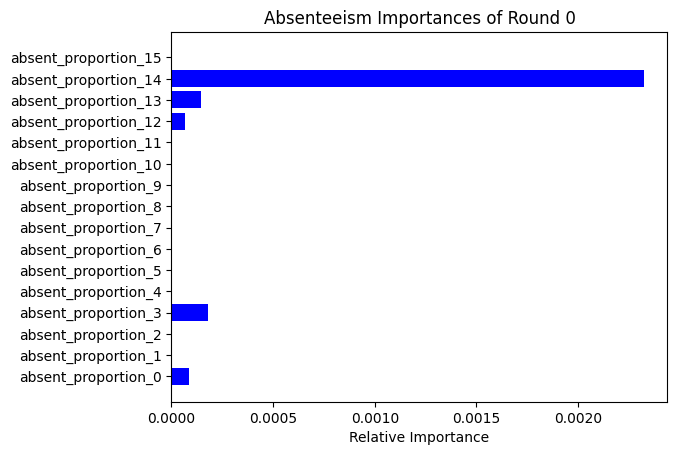

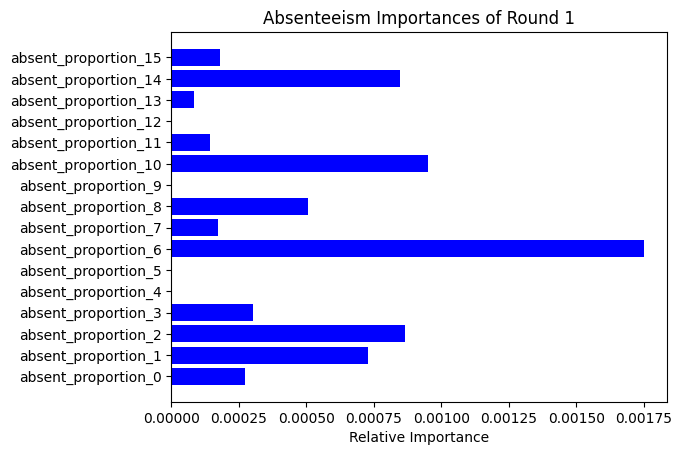

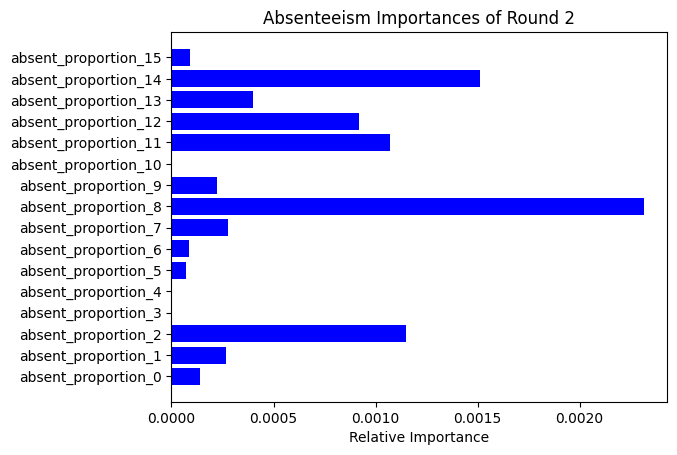

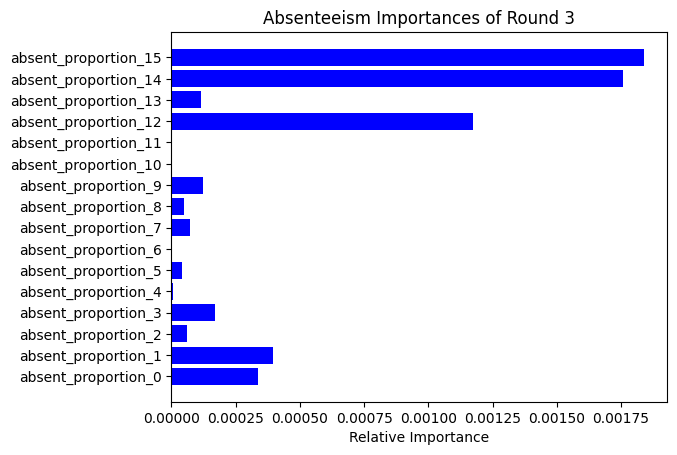

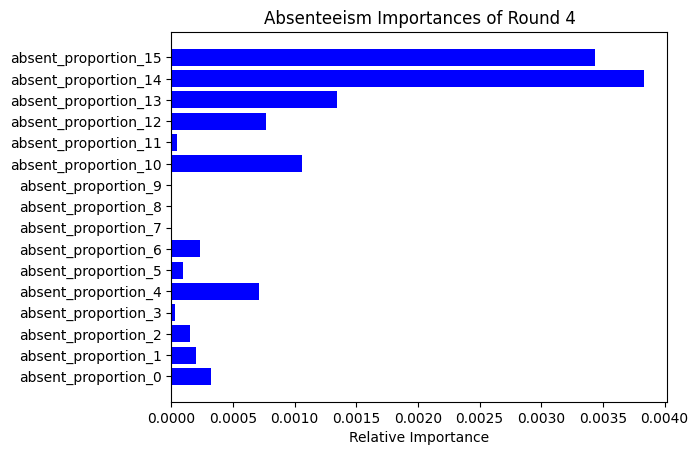

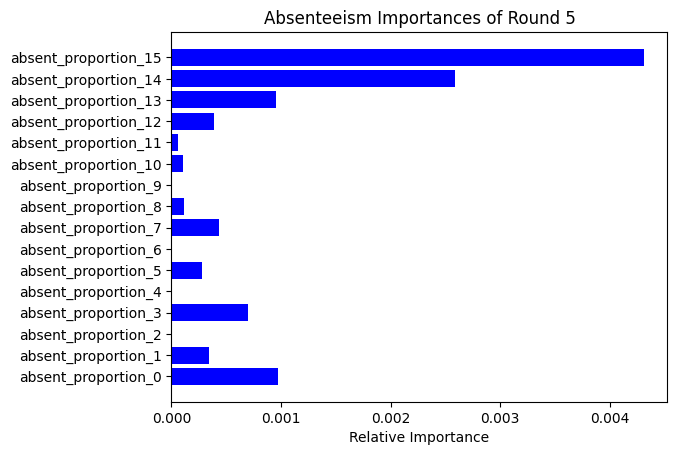

In [28]:
if IS_ABSEN:
    for round in range(6):
        absent_importances = ls_absent_importances[round]
        plt.title('Absenteeism Importances of Round '+str(round))
        plt.barh(range(len(absent_importances)), absent_importances, color='b', align='center')
        plt.yticks(range(len(absent_importances)), [feat_names[14]+'_'+str(i) for i in range(len(absent_importances))])
        plt.xlabel('Relative Importance')
        plt.show()

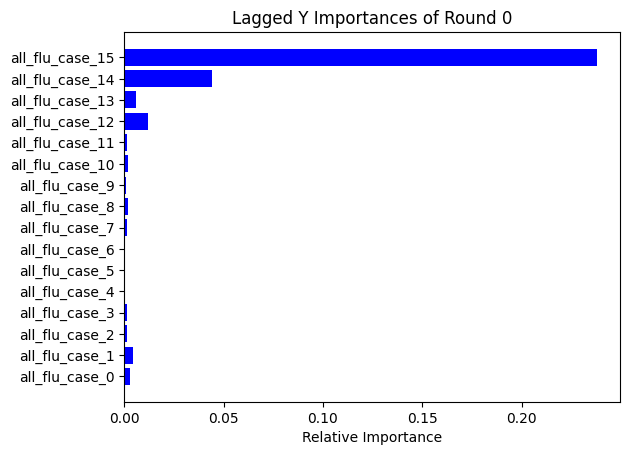

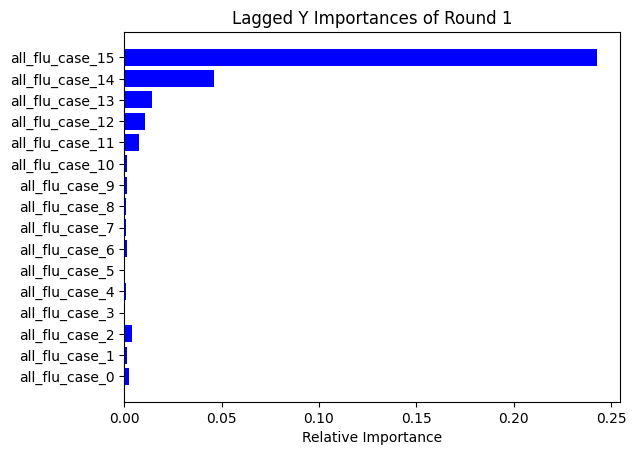

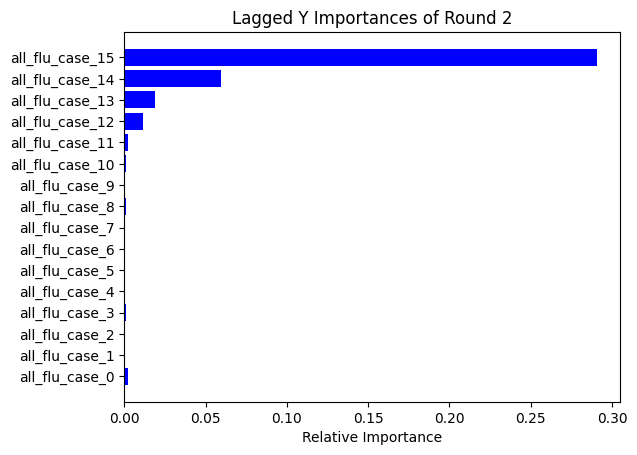

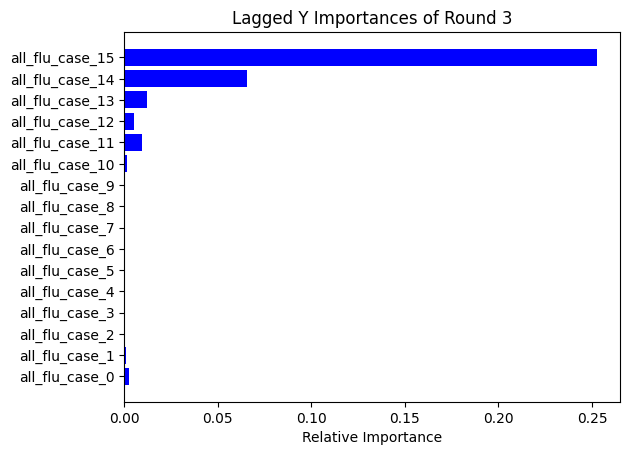

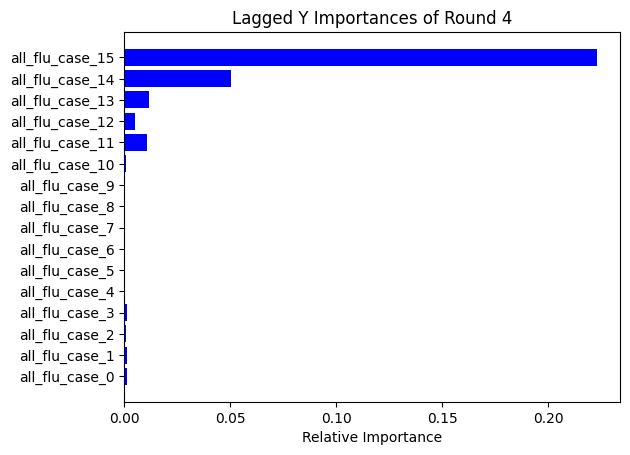

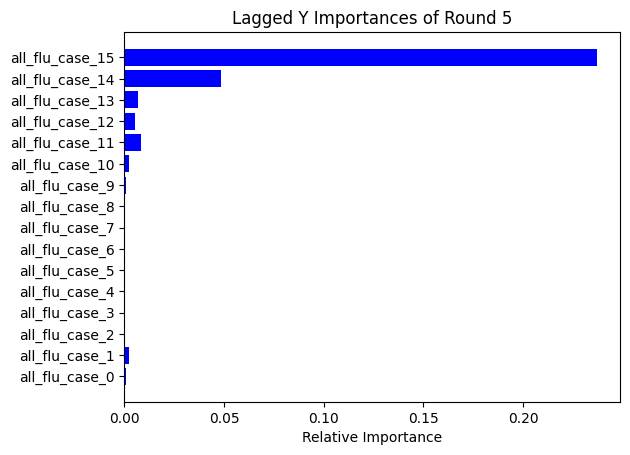

In [29]:
for round in range(6):
    lag_y_importances = ls_lag_y_importances[round]
    plt.title('Lagged Y Importances of Round '+str(round))
    plt.barh(range(len(lag_y_importances)), lag_y_importances, color='b', align='center')
    plt.yticks(range(len(lag_y_importances)), [feat_names[7]+'_'+str(i) for i in range(len(lag_y_importances))])
    plt.xlabel('Relative Importance')
    plt.show()

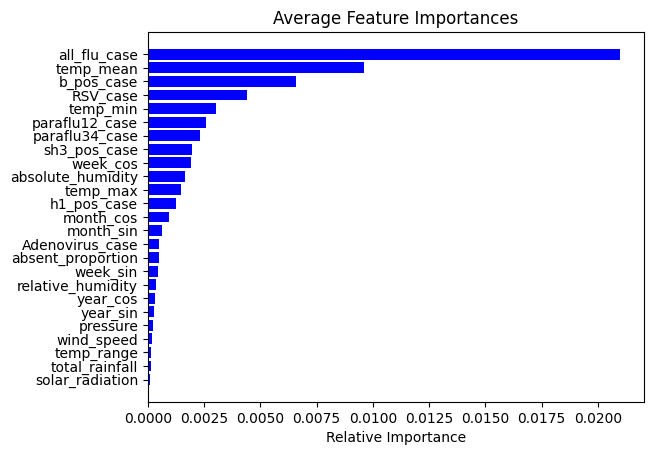

In [30]:
avg2_importances = np.mean(ls_avg_importances, axis=0)
indices2 = np.argsort(avg2_importances)

plt.title('Average Feature Importances')
plt.barh(range(len(indices2)), avg2_importances[indices2], color='b', align='center')
plt.yticks(range(len(indices2)), [feat_names[i] for i in indices2])
plt.xlabel('Relative Importance')
plt.show()

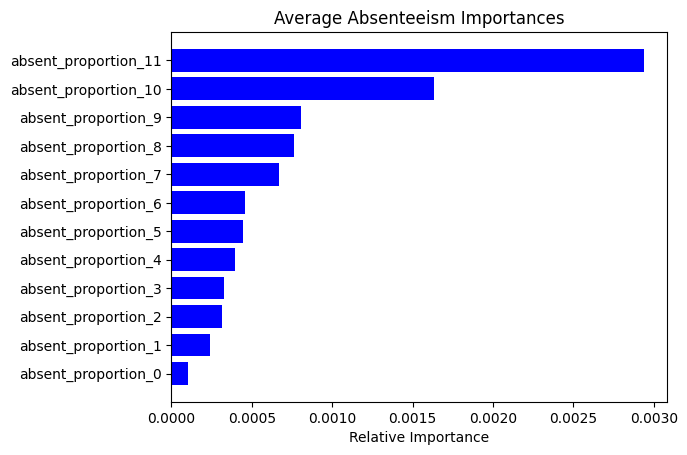

In [55]:
avg_absent_importances = np.mean(ls_absent_importances, axis=0)
indices2 = np.argsort(avg_absent_importances)

plt.title('Average Absenteeism Importances')
plt.barh(range(len(indices2)), avg_absent_importances[indices2], color='b', align='center')
plt.yticks(range(len(indices2)), [feat_names[14]+'_'+str(i) for i in range(len(absent_importances))])
plt.xlabel('Relative Importance')
plt.show()

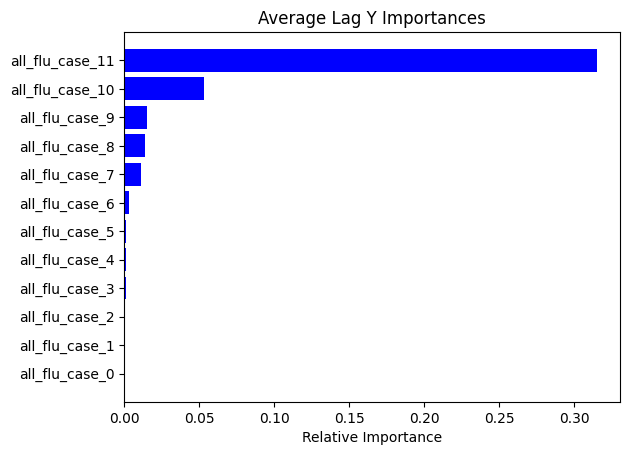

In [56]:
avg_lag_y_importances = np.mean(ls_lag_y_importances, axis=0)
indices2 = np.argsort(avg_lag_y_importances)

plt.title('Average Lag Y Importances')
plt.barh(range(len(indices2)), avg_lag_y_importances[indices2], color='b', align='center')
plt.yticks(range(len(indices2)), [feat_names[7]+'_'+str(i) for i in range(len(lag_y_importances))])
plt.xlabel('Relative Importance')
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, explained_variance_score

# https://pytorch-forecasting.readthedocs.io/en/stable/api/pytorch_forecasting.metrics.point.SMAPE.html?highlight=smape
def symmetric_mean_absolute_percentage(y_true, y_pred):
    value = 2*abs(y_true - y_pred) / (abs(y_true) + abs(y_pred))
    # for cases when both ground truth and predicted value are zero
    value = np.where(np.isnan(value), 0, value)

    return np.mean(value)

# https://en.wikipedia.org/wiki/Nash%E2%80%93Sutcliffe_model_efficiency_coefficient
# NSE is equivalent to https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html#sklearn.metrics.explained_variance_score
def normalized_nash_sutcliffe_efficiency(y_true, y_pred):
    # numerator = sum (np.square(y_true - y_pred) )
    # denominator = sum(np.square(y_true - np.mean(y_true)))
    # NSE = 1 - numerator / denominator
    NSE = explained_variance_score(y_true, y_pred)
    return 1 / ( 2 - NSE)

def calculate_result(y_true, y_pred,print_option = True):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    #rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    smape = symmetric_mean_absolute_percentage(y_true, y_pred)
    nnse = normalized_nash_sutcliffe_efficiency(y_true, y_pred)
    if print_option:
        print(f'MAE {mae:.4g}, RMSE {rmse:.4g}, SMAPE {smape:0.4g}, NNSE {nnse:0.4g}.')
    return mae, rmse, smape, nnse

def convert_multi_pred_to_single(predictions,time_index):
    results = {}
    #predictions = ls_y_test_pred[round0]
    #time_index = y_test_date_idx
    for index in range(len(predictions)):
            current_time_index = time_index[index]

            for time_step in range(FORECAST_RANGE):
                if index+time_step< len(predictions):
                    item = time_index[index+time_step]
                    predicted_value = predictions[index][time_step]

                    if item in results:
                        results[item].append(predicted_value)
                    else:
                        results[item] = [predicted_value]

    adj_predictions = []
    for key in results.keys():
            item = results[key]

            adj_predictions.append(np.mean(item))
        
    result_df = pd.DataFrame({
            f'Predicted_{y_col}': adj_predictions  
        })
    return result_df

In [32]:
os.chdir('/Users/yanchen/Dropbox/hksph/hksph-project/result-072024/rf/rf_interval_none_no_absent')
#os.chdir('/Users/yanchen/Dropbox/hksph/hksph-project/result-072024/rf/rf_interval_log_diff')
#os.chdir('/Users/yanchen/Dropbox/hksph/hksph-project/result-052024/rf/rf_interval_log')
#os.chdir('/Users/yanchen/Dropbox/hksph/hksph-project/result-072024/rf/rf_interval_deduct_8')

In [33]:
#y_convert_mode ='log_diff'
#y_convert_mode ='log'
#y_convert_mode ='deduct-8'
#y_convert_mode = 'stand'
is_choose_one_duration = False
ls_df_test_compare = []
ls_y_pred = []
ls_y_true = []
if y_convert_mode == 'log_diff':
  ls_q_forecsts = []
for round0 in range(len(ls_y_train_pred)):
  round1 = round0 + 1
  y_test_date_idx = np.concatenate(ls_Y_test_date[round0:round1])[:,FORECAST_RANGE - 1].flatten()
  y_test_pred = ls_y_test_pred[round0].flatten()
  y_test = ls_Y_test[round0].flatten()


  train_temp = np.concatenate(ls_Y_train_date[round0:round1])[:,FORECAST_RANGE - 1].flatten()[-1]

  train_timestamp = ((train_temp - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))

  print('train end date: ',datetime.utcfromtimestamp(train_timestamp))

  test_temp = np.concatenate(ls_Y_test_date[round0:round1])[:,FORECAST_RANGE - 1].flatten()[0]

  test_timestamp = ((test_temp - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))

  print('test start date: ',datetime.utcfromtimestamp(test_timestamp))

  if FORECAST_RANGE>1:
    multi_pred = ls_y_test_pred[round0]
    if y_convert_mode =='stand':
      multi_pred = ss_transformer.inverse_transform(multi_pred)
    
    if is_choose_one_duration:
      single_pred =ls_y_test_pred[round0][:,7]
      single_test =ls_Y_test[round0][:,7]
    else:
      single_pred = convert_multi_pred_to_single(multi_pred,y_test_date_idx)
      single_test = convert_multi_pred_to_single(ls_Y_test[round0],y_test_date_idx)
    
    
  else:
    single_pred = y_test_pred
    single_test = y_test
    
  if y_convert_mode =='log_diff':
    #single_pred =ls_y_test_pred[round0][:,7]
    #single_test =ls_Y_test[round0][:,7]
    single_pred = np.exp(np.cumsum(single_pred))*ls_Y_test_last[round0][7]
    #single_test = np.exp(np.cumsum(single_test))*ls_Y_test_last[round0][7]
  
  if y_convert_mode =='log':
    single_pred = log1p_transformer.inverse_transform(single_pred)
  #single_low = log1p_transformer.inverse_transform(single_low)
  #single_high = log1p_transformer.inverse_transform(single_high)
  
  mae, rmse, smape, nnse = calculate_result(single_test, single_pred)
  ls_y_pred.append(single_pred)
  ls_y_true.append(single_test)

  alphas = ls_q_forecasts[round0].keys()
  if y_convert_mode =='log_diff':
  #  alphas = [a  for a in alphas if a<=0.55]

      q_dict = {}
    # Generating the error distribution
      
      y_train = ls_y_train[round0]
      if y_train.shape[1]==1:
        #resid = y_train.squeeze() - rf_best.oob_prediction_
        resid = y_train - ls_y_train_pred[round0].reshape(-1,1)
      else:
        resid = y_train - ls_y_train_pred[round0]
      
      for alpha in alphas:
        lowq = pd.DataFrame(resid).quantile(alpha/2)
        higq = pd.DataFrame(resid).quantile(1-alpha/2)
        
        lowt = (ls_y_test_pred[round0] + lowq.values)
        higt = (ls_y_test_pred[round0] + higq.values)

        q_dict[alpha/2]=lowt
        q_dict[1-alpha/2]=higt

      ls_q_forecsts.append(q_dict)

  if FORECAST_RANGE==1: 
    df_test_compare = pd.DataFrame(np.hstack((single_test.reshape(-1,1),
                                          single_pred.reshape(-1,1),)),
                              columns = ['y_test','y_pred'])
    for alpha in alphas:
      df_test_compare[alpha] = ls_q_forecasts[round0][alpha]
  else:
    if is_choose_one_duration:
      df_test_compare = pd.DataFrame(np.hstack((single_test.reshape(-1,1),
                                          single_pred.reshape(-1,1))),
                               columns = ['y_test','y_pred'])
      
    else:
      df_test_compare = pd.DataFrame(np.hstack((single_test,
                                          single_pred)),
                               columns = ['y_test','y_pred'])
  

  
    for alpha in alphas:
      tmp = convert_multi_pred_to_single(ls_q_forecasts[round0][alpha],y_test_date_idx)
      df_test_compare[alpha] = tmp.values
      if y_convert_mode =='log_diff':
        df_test_compare[alpha] = np.exp(np.cumsum(tmp.values))*ls_Y_test_last[round0][7]
  
  df_test_compare.index = y_test_date_idx
  ls_df_test_compare.append(df_test_compare)
  
  title_str = 'RF Regression test actual vs test predicted'

  plt.plot(df_test_compare.index, df_test_compare['y_pred'], label = 'y_pred')
  #plt.fill_between(df_test_compare.index, df_test_compare['pred_low'], df_test_compare['pred_high'], alpha=0.2)
  plt.plot(df_test_compare.index, df_test_compare['y_test'], label = 'y_test')
  plt.xticks(rotation=90)
  plt.legend()
  plt.title(title_str)
  #plt.show()
  tmp_test_start = pd.to_datetime(y_test_date_idx[0])
  plt.savefig('test-start-'+str(tmp_test_start.date())+'-lookback-'+str(LOOK_BACK))
  plt.close()

train end date:  2013-10-20 00:00:00
test start date:  2013-11-03 00:00:00
MAE 2.43, RMSE 3.014, SMAPE 0.5769, NNSE 0.7015.
train end date:  2014-10-19 00:00:00
test start date:  2014-11-02 00:00:00
MAE 3.236, RMSE 4.829, SMAPE 0.6783, NNSE 0.6425.
train end date:  2015-10-25 00:00:00
test start date:  2015-11-01 00:00:00
MAE 1.908, RMSE 2.634, SMAPE 0.6188, NNSE 0.784.
train end date:  2016-10-23 00:00:00
test start date:  2016-11-06 00:00:00
MAE 3.017, RMSE 5.225, SMAPE 0.3989, NNSE 0.6231.
train end date:  2017-10-22 00:00:00
test start date:  2017-11-05 00:00:00
MAE 2.133, RMSE 3.163, SMAPE 0.7039, NNSE 0.7212.
train end date:  2018-10-21 00:00:00
test start date:  2018-11-04 00:00:00
MAE 1.828, RMSE 2.581, SMAPE 0.5107, NNSE 0.6469.


In [34]:

total_df_test_compare = pd.concat(ls_df_test_compare)
quantile_dict_test = {}
for alpha in alphas:
    quantile_dict_test[alpha] = total_df_test_compare[alpha].values
#os.chdir('/Users/yanchen/Dropbox/hksph/hksph-project/result-072024/rf/rf_interval_none')
total_df_test_compare.to_csv(f'{sample_weight_mode}_weight_lookback{LOOK_BACK}week_forecast{FORECAST_RANGE}week_total_df_test_compare.csv')


In [35]:
observations_test = total_df_test_compare['y_test'].values
IS = weighted_interval_score_fast(observations_test,
                                         alphas=list_alpha,q_dict=quantile_dict_test,
                                         percent=True)
mean_IS = np.mean(IS[0])
mean_IS


2.532792775117462

MAE 2.426, RMSE 3.727, SMAPE 0.5817, NNSE 0.6737.


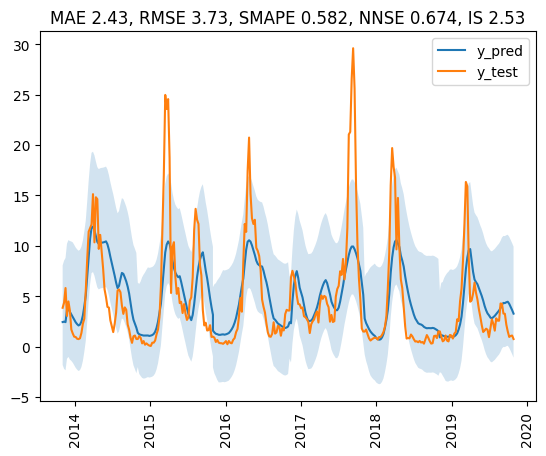

In [36]:

#os.chdir('/Users/yanchen/Dropbox/hksph/hksph-project/result-072024/rf/rf_interval_none')
if is_plot_total:
      plt.plot(total_df_test_compare.index, total_df_test_compare['y_pred'], label = 'y_pred')
      single_high = total_df_test_compare[0.95]
      single_low = total_df_test_compare[0.05]
      if y_convert_mode =='log':
            single_high = log1p_transformer.inverse_transform(single_high)
            single_low = log1p_transformer.inverse_transform(single_low)
      plt.fill_between(total_df_test_compare.index, single_low, single_high, alpha=0.2)
      #plt.fill_between(total_df_test_compare.index, total_df_test_compare['pred_low'], total_df_test_compare['pred_high'], alpha=0.2)
      plt.plot(total_df_test_compare.index, total_df_test_compare['y_test'], label = 'y_test')
      plt.xticks(rotation=90)
      plt.legend()
      mae, rmse, smape, nnse = calculate_result(total_df_test_compare['y_test'], total_df_test_compare['y_pred'])
      #IS = interval_score(total_df_test_compare['y_test'],total_df_test_compare['y_pred'],
      #              q_left=total_df_test_compare['pred_low'],q_right=total_df_test_compare['pred_high'])
      #mean_is = np.mean(IS[0]) #total = sharpness + calibration
      title = f'MAE {mae:0.3g}, RMSE {rmse:0.3g}, SMAPE {smape:0.3g}, NNSE {nnse:0.3g}, IS {mean_IS:0.3g}'
      plt.title(title)
      #plt.show()
      target_figure_name = f'{model_type}_lookback{LOOK_BACK}week_forecast{FORECAST_RANGE}week_summed_plot_{sample_weight_mode}.jpg'
      plt.savefig(target_figure_name)

In [37]:
if FORECAST_RANGE>1: 
    total_y_pred = pd.concat(ls_y_pred)
    total_y_true = pd.concat(ls_y_true)
else:
    total_y_pred = np.concatenate(ls_y_pred)
    total_y_true = np.concatenate(ls_y_true)
mae, rmse, smape, nnse = calculate_result(total_y_true, total_y_pred)

MAE 2.426, RMSE 3.727, SMAPE 0.5817, NNSE 0.6737.


In [28]:
hparam_dict

{'n_estimators': 80,
 'max_features': 200,
 'max_depth': 20,
 'min_samples_split': 10,
 'min_samples_leaf': 8,
 'criterion': 'absolute_error',
 'bootstrap': True,
 'train_start_fix': 1}

In [29]:
n_estimators = [20,50,80] # number of trees in the random forest
max_features = [20,50,200] # number of features in consideration at every split
max_depth = [5,20]
#max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [10, 18] # minimum sample number to split a node
min_samples_leaf = [4,8] # minimum sample number that can be stored in a leaf node
bootstrap = [True] # method used to sample data points
criterion = ['squared_error','absolute_error']
train_start_fix = [1]
random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'criterion': criterion,
'bootstrap': bootstrap,
'train_start_fix': train_start_fix}

In [30]:
config = list(random_grid.values())
config

[[20, 50, 80],
 [20, 50, 200],
 [5, 20],
 [10, 18],
 [4, 8],
 ['squared_error', 'absolute_error'],
 [True],
 [1]]

In [33]:
import itertools
#def LSTM_HyperParameter_Tuning(config, df_full):
if True:
    n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, criterion, bootstrap, train_start_fix= config
    possible_combinations = list(itertools.product(n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, criterion, bootstrap,train_start_fix))

    print('Number of possible combinations',len(possible_combinations))
    print('\n')

    hist = []
    hparam_dict_tune = {}
    

    for i in range(0, len(possible_combinations)):
        n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, criterion, bootstrap,train_start_fix = possible_combinations[i]
        
        hparam_dict_tune['n_estimators'] = n_estimators
        hparam_dict_tune['max_features'] = max_features
        hparam_dict_tune['max_depth'] = max_depth
        hparam_dict_tune['min_samples_split'] = min_samples_split
        hparam_dict_tune['min_samples_leaf']=min_samples_leaf
        hparam_dict_tune['criterion']=criterion
        hparam_dict_tune['bootstrap']=bootstrap
        hparam_dict_tune['train_start_fix']=train_start_fix

        #test for five different random state
        tmp_arr = np.zeros((5,4)) #store test_mae, test_rmse, test_rmsle, test_smape, test_nnse
        for my_seed in range(5):
            ls_q_forecasts,rf_best,ls_Y_train_pred,ls_y_train_pred,ls_y_val_pred,ls_y_test_pred,ls_Y_train, ls_y_train, ls_Y_test,ls_Y_test_last,ls_Y_train_date, ls_Y_test_date, ls_importance, ls_importance_std = my_rolling_train(df_raw_adj, FORECAST_RANGE = FORECAST_RANGE, y_col = y_col
                                                                                                                                                                                         ,hparam_dict = hparam_dict_tune, seed = SEED, 
                                                                                                                                                                                         sample_weight_mode= sample_weight_mode,
                                                                                                                                                                                         y_convert_mode = y_convert_mode)
        
            ls_df_test_compare = []
            ls_y_pred = []
            ls_y_true = []
            for round0 in range(len(ls_y_train_pred)):
                round1 = round0 + 1
                y_test_date_idx = np.concatenate(ls_Y_test_date[round0:round1])[:,FORECAST_RANGE - 1].flatten()
                y_test_pred = ls_y_test_pred[round0].flatten()
                y_test = ls_Y_test[round0].flatten()


                train_temp = np.concatenate(ls_Y_train_date[round0:round1])[:,FORECAST_RANGE - 1].flatten()[-1]

                train_timestamp = ((train_temp - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))

                test_temp = np.concatenate(ls_Y_test_date[round0:round1])[:,FORECAST_RANGE - 1].flatten()[0]

                test_timestamp = ((test_temp - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))

                if FORECAST_RANGE>1:
                    single_pred = convert_multi_pred_to_single(ls_y_test_pred[round0],y_test_date_idx)
                    single_test = convert_multi_pred_to_single(ls_Y_test[round0],y_test_date_idx)
                    #if bootstrap:
                    #    single_low = convert_multi_pred_to_single(ls_lowt[round0],y_test_date_idx)
                    #    single_high = convert_multi_pred_to_single(ls_higt[round0],y_test_date_idx)
                else:
                    single_pred = y_test_pred
                    single_test = y_test
                    #if bootstrap:
                    #    single_low = ls_lowt[round0].flatten()
                    #    single_high = ls_higt[round0].flatten()
                ls_y_pred.append(single_pred)
                ls_y_true.append(single_test)
                if bootstrap:
                    df_test_compare = pd.DataFrame(np.hstack((single_test,
                                          single_pred)),
                               columns = ['y_test','y_pred'])
                else:
                    df_test_compare = pd.DataFrame(np.hstack((single_test,
                                          single_pred)),
                               columns = ['y_test','y_pred'])
                df_test_compare.index = y_test_date_idx
                ls_df_test_compare.append(df_test_compare.std())
        
            total_y_pred = pd.concat(ls_y_pred)
            total_y_true = pd.concat(ls_y_true)
            #test_mae, test_rmse, test_rmsle, test_smape, test_nnse = calculate_result(total_y_true, total_y_pred,print_option = False)
            #tmp_arr[my_seed,:] = test_mae, test_rmse, test_rmsle, test_smape, test_nnse
            tmp_arr[my_seed,:] =calculate_result(total_y_true, total_y_pred,print_option = False)
        test_mae, test_rmse, test_smape, test_nnse = np.mean(tmp_arr, axis = 0)  
        hist.append(list((n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf, criterion, bootstrap,train_start_fix,
                          test_mae, test_rmse, test_smape, test_nnse)))

        print(f'{str(i+1)}-th combination = {possible_combinations[i]} \n test rmse: {test_rmse} \n and test mae: {test_mae} ')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')

    #return hist

Number of possible combinations 144


iteration 0
train_end_date_dt 2013-10-25 00:00:00
test_start_date_dt 2013-11-01 00:00:00
X.shape before squeeze (249, 12, 25)
X.shape after squeeze (249, 300)
number of features 300
iteration 1
train_end_date_dt 2014-10-25 00:00:00
test_start_date_dt 2014-11-01 00:00:00
X.shape before squeeze (302, 12, 25)
X.shape after squeeze (302, 300)
number of features 300
iteration 2
train_end_date_dt 2015-10-25 00:00:00
test_start_date_dt 2015-11-01 00:00:00
X.shape before squeeze (355, 12, 25)
X.shape after squeeze (355, 300)
number of features 300
iteration 3
train_end_date_dt 2016-10-24 00:00:00
test_start_date_dt 2016-10-31 00:00:00
X.shape before squeeze (406, 12, 25)
X.shape after squeeze (406, 300)
number of features 300
iteration 4
train_end_date_dt 2017-10-24 00:00:00
test_start_date_dt 2017-10-31 00:00:00
X.shape before squeeze (458, 12, 25)
X.shape after squeeze (458, 300)
number of features 300
iteration 5
train_end_date_dt 2018-10-24 00:00:00
te

In [106]:
df_hist = pd.DataFrame(hist)
df_hist.min()


0                 20
1                 20
2                  5
3                 10
4                  4
5     absolute_error
6               True
7                  0
8           2.146552
9           3.100323
10          0.477279
11          0.515091
12          0.650731
dtype: object

In [72]:
df_hist.to_csv('rf_with_absence_hyperparameter_tuning.csv')

In [4]:
import os
os.chdir('/Users/yanchen/Dropbox/hksph/hksph-project/result-052024/')
df_rf_1w = pd.read_csv('rf/bin_weight_1week_total_df_test_compare.csv',index_col=0)
df_rf_2w = pd.read_csv('rf/bin_weight_2week_total_df_test_compare.csv',index_col=0)
df_rf_4w = pd.read_csv('rf/bin_weight_4week_total_df_test_compare.csv',index_col=0)
df_rf_8w = pd.read_csv('rf/bin_weight_8week_total_df_test_compare.csv',index_col=0)


In [15]:
print("================== random forest===========")
print('==================1 week===================')
mae, rmse, smape, nnse = calculate_result(df_rf_1w['y_test'], df_rf_1w['y_pred'])

print('==================2 week===================')
mae, rmse, smape, nnse = calculate_result(df_rf_2w['y_test'], df_rf_2w['y_pred'])

print('==================4 week===================')
mae, rmse, smape, nnse = calculate_result(df_rf_4w['y_test'], df_rf_4w['y_pred'])

print('==================8 week===================')
mae, rmse, smape, nnse = calculate_result(df_rf_8w['y_test'], df_rf_8w['y_pred'])

================== random forest===========
==================1 week===================
MAE 1.379, RMSE 2.418, SMAPE 0.3393, NNSE 0.8325.
==================2 week===================
MAE 1.618, RMSE 2.717, SMAPE 0.3848, NNSE 0.7974.
==================4 week===================
MAE 1.944, RMSE 3.12, SMAPE 0.452, NNSE 0.7491.
==================8 week===================
MAE 2.324, RMSE 3.583, SMAPE 0.5537, NNSE 0.691.


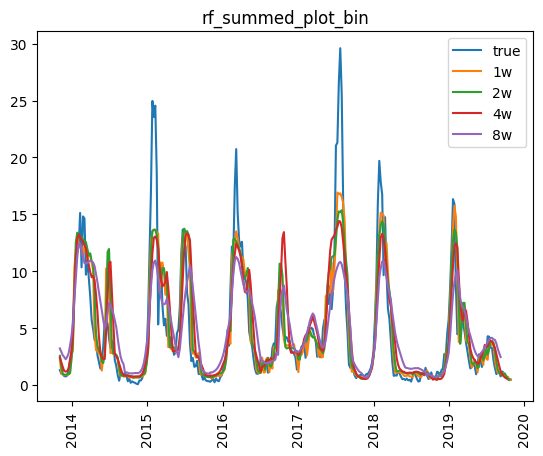

In [8]:
model_type = 'rf'
sample_weight_mode = 'bin'
df_rf_1w.index = pd.to_datetime(df_rf_1w.index , format = '%Y-%m-%d')
#df_rf_2w.index = pd.to_datetime(df_rf_2w.index , format = '%Y-%m-%d')
if True:
    plt.plot(df_rf_1w.index, df_rf_1w['y_test'], label = 'true')
    #plt.plot(df_rf_2w.index, df_rf_2w['y_test'], label = 'true')
    plt.plot(list(df_rf_1w.index), df_rf_1w['y_pred'], label = '1w')
    plt.plot(list(df_rf_1w.index[:-1]), df_rf_2w['y_pred'][1:], label = '2w')
    plt.plot(list(df_rf_1w.index[:-3]), df_rf_4w['y_pred'][3:], label = '4w')
    plt.plot(list(df_rf_1w.index[:-7]), df_rf_8w['y_pred'][7:], label = '8w')
    """
    plt.plot(list(df_rf_2w.index), df_rf_2w['y_pred'], label = '2w')
    plt.plot(list(df_rf_2w.index[:-2]), df_rf_4w['y_pred'][2:], label = '4w')
    plt.plot(list(df_rf_2w.index[:-6]), df_rf_8w['y_pred'][6:], label = '8w')
    """
    #plt.plot(list(df_rf_2w.index), df_rf_4w['y_pred'], label = '4w')
    #plt.plot(list(df_rf_2w.index), df_rf_8w['y_pred'], label = '8w')
    plt.xticks(rotation=90)
    plt.legend()
    #mae, rmse, rmsle, smape, nnse = calculate_result(total_df_test_compare['y_test'], total_df_test_compare['y_pred'])
    #title = f'MAE {mae:0.3g}, RMSE {rmse:0.3g}, RMSLE {rmsle:0.3g}, SMAPE {smape:0.3g}, NNSE {nnse:0.3g}, IS {mean_IS:0.3g}'
    plt.title(f'{model_type}_summed_plot_{sample_weight_mode}')
      
    target_figure_name = f'{model_type}_0610_summed_plot_{sample_weight_mode}.jpg'
    #plt.savefig(target_figure_name)
    plt.show()

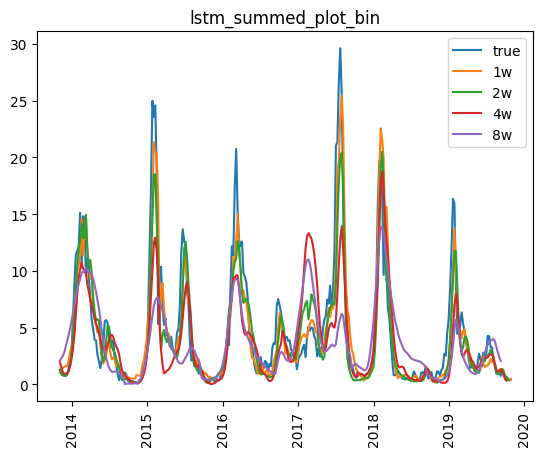

In [9]:
import os
os.chdir('/Users/yanchen/Dropbox/hksph/hksph-project/result-052024/')
df_lstm_1w = pd.read_csv('lstm/bin_weight_1week_total_df_test_compare.csv',index_col=0)
df_lstm_2w = pd.read_csv('lstm/bin_weight_2week_total_df_test_compare.csv',index_col=0)
df_lstm_4w = pd.read_csv('lstm/bin_weight_4week_total_df_test_compare.csv',index_col=0)
df_lstm_8w = pd.read_csv('lstm/bin_weight_8week_total_df_test_compare.csv',index_col=0)

model_type = 'lstm'
sample_weight_mode = 'bin'
df_lstm_1w.index = pd.to_datetime(df_lstm_1w.index , format = '%Y-%m-%d')
#df_lstm_2w.index = pd.to_datetime(df_lstm_2w.index , format = '%Y-%m-%d')
if True:
    plt.plot(df_lstm_1w.index, df_lstm_1w['y_test'], label = 'true')
    plt.plot(list(df_lstm_1w.index), df_lstm_1w['y_pred'], label = '1w')
    plt.plot(list(df_lstm_1w.index[:-1]), df_lstm_2w['y_pred'][1:], label = '2w')
    plt.plot(list(df_lstm_1w.index[:-3]), df_lstm_4w['y_pred'][3:], label = '4w')
    plt.plot(list(df_lstm_1w.index[:-7]), df_lstm_8w['y_pred'][7:], label = '8w')
    """
    plt.plot(df_lstm_2w.index, df_lstm_2w['y_test'], label = 'true')
    plt.plot(list(df_lstm_2w.index), df_lstm_2w['y_pred'], label = '2w')
    #plt.plot(list(df_lstm_2w.index[:-2]), df_lstm_4w['y_pred'][2:], label = '4w')
    #plt.plot(list(df_lstm_2w.index[:-6]), df_lstm_8w['y_pred'][6:], label = '8w')
    plt.plot(list(df_lstm_2w.index), df_lstm_4w['y_pred'], label = '4w')
    plt.plot(list(df_lstm_2w.index), df_lstm_8w['y_pred'], label = '8w')
    """
    plt.xticks(rotation=90)
    plt.legend()
    plt.title(f'{model_type}_summed_plot_{sample_weight_mode}')
      
    target_figure_name = f'{model_type}_summed_plot_{sample_weight_mode}.jpg'
    #plt.savefig(target_figure_name)
    plt.show()


In [16]:
print("================== LSTM ===========")
print('==================1 week===================')
mae, rmse, smape, nnse = calculate_result(df_lstm_1w['y_test'], df_lstm_1w['y_pred'])

print('==================2 week===================')
mae, rmse, smape, nnse = calculate_result(df_lstm_2w['y_test'], df_lstm_2w['y_pred'])

print('==================4 week===================')
mae, rmse, smape, nnse = calculate_result(df_lstm_4w['y_test'], df_lstm_4w['y_pred'])

print('==================8 week===================')
mae, rmse, smape, nnse = calculate_result(df_lstm_8w['y_test'], df_lstm_8w['y_pred'])

================== LSTM ===========
==================1 week===================
MAE 1.387, RMSE 2.248, SMAPE 0.3787, NNSE 0.8535.
==================2 week===================
MAE 1.559, RMSE 2.497, SMAPE 0.4128, NNSE 0.8306.
==================4 week===================
MAE 2.256, RMSE 3.74, SMAPE 0.5313, NNSE 0.6876.
==================8 week===================
MAE 2.754, RMSE 4.523, SMAPE 0.6468, NNSE 0.5975.


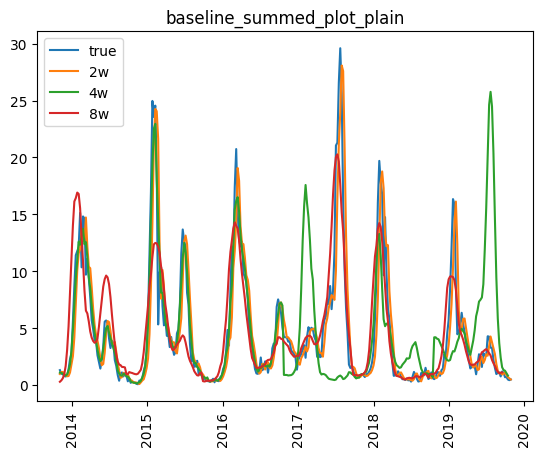

In [17]:
import os
os.chdir('/Users/yanchen/Dropbox/hksph/hksph-project/result-052024/')
df_baseline_2w = pd.read_csv('baseline/plain_weight_2week_total_df_test_compare.csv',index_col=0)
df_baseline_4w = pd.read_csv('baseline/plain_weight_4week_total_df_test_compare.csv',index_col=0)
df_baseline_8w = pd.read_csv('baseline/plain_weight_8week_total_df_test_compare.csv',index_col=0)

model_type = 'baseline'
sample_weight_mode = 'plain'
df_baseline_2w.Date = pd.to_datetime(df_baseline_2w.Date , format = '%Y-%m-%d')
if True:
    plt.plot(df_baseline_2w.Date, df_baseline_2w['all_flu_case'], label = 'true')
    plt.plot(list(df_baseline_2w.Date), df_baseline_2w['Predicted_all_flu_case'], label = '2w')
    plt.plot(list(df_baseline_2w.Date[:-2]), df_baseline_4w['Predicted_all_flu_case'][2:], label = '4w')
    plt.plot(list(df_baseline_2w.Date[:-6]), df_baseline_8w['Predicted_all_flu_case'][6:], label = '8w')
    #plt.plot(list(df_baseline_2w.Date), df_baseline_4w['Predicted_all_flu_case'], label = '4w')
    #plt.plot(list(df_baseline_2w.Date), df_baseline_8w['Predicted_all_flu_case'], label = '8w')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title(f'{model_type}_summed_plot_{sample_weight_mode}')
      
    target_figure_name = f'{model_type}_summed_plot_{sample_weight_mode}.jpg'
    #plt.savefig(target_figure_name)
    plt.show()


In [19]:
print("================== Baseline ===========")

print('==================2 week===================')
mae, rmse, smape, nnse = calculate_result(df_baseline_2w['all_flu_case'], df_baseline_2w['Predicted_all_flu_case'])

print('==================4 week===================')
mae, rmse, smape, nnse = calculate_result(df_baseline_4w['all_flu_case'], df_baseline_4w['Predicted_all_flu_case'])

print('==================8 week===================')
mae, rmse, smape, nnse = calculate_result(df_baseline_8w['all_flu_case'], df_baseline_8w['Predicted_all_flu_case'])

================== Baseline ===========
==================2 week===================
MAE 1.523, RMSE 2.659, SMAPE 0.3508, NNSE 0.8043.
==================4 week===================
MAE 2.175, RMSE 3.613, SMAPE 0.464, NNSE 0.6899.
==================8 week===================
MAE 3.163, RMSE 4.879, SMAPE 0.6515, NNSE 0.5496.


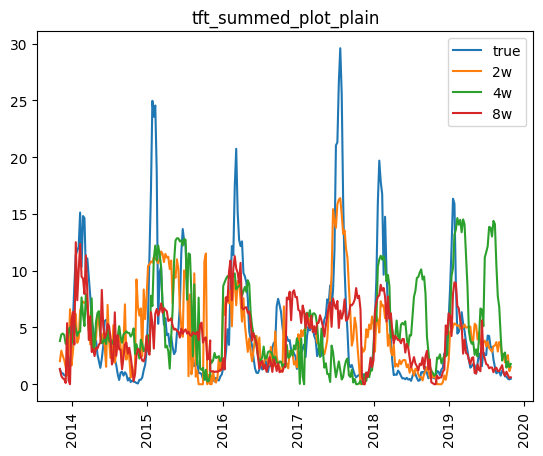

In [20]:
import os
os.chdir('/Users/yanchen/Dropbox/hksph/hksph-project/result-052024/')
df_tft_2w = pd.read_csv('tft/plain_weight_2week_total_df_test_compare.csv',index_col=0)
df_tft_4w = pd.read_csv('tft/plain_weight_4week_total_df_test_compare.csv',index_col=0)
df_tft_8w = pd.read_csv('tft/plain_weight_8week_total_df_test_compare.csv',index_col=0)

model_type = 'tft'
sample_weight_mode = 'plain'
df_tft_2w.Date = pd.to_datetime(df_tft_2w.Date , format = '%Y-%m-%d')
if True:
    plt.plot(df_tft_2w.Date, df_tft_2w['all_flu_case'], label = 'true')
    plt.plot(list(df_tft_2w.Date), df_tft_2w['Predicted_all_flu_case'], label = '2w')
    #plt.plot(list(df_tft_2w.Date[:-2]), df_tft_4w['Predicted_all_flu_case'][2:], label = '4w')
    #plt.plot(list(df_tft_2w.Date[:-6]), df_tft_8w['Predicted_all_flu_case'][6:], label = '8w')
    plt.plot(list(df_tft_2w.Date), df_tft_4w['Predicted_all_flu_case'], label = '4w')
    plt.plot(list(df_tft_2w.Date), df_tft_8w['Predicted_all_flu_case'], label = '8w')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title(f'{model_type}_summed_plot_{sample_weight_mode}')
      
    target_figure_name = f'{model_type}_summed_plot_{sample_weight_mode}.jpg'
    #plt.savefig(target_figure_name)
    plt.show()


In [21]:
print("================== TFT ===========")

print('==================2 week===================')
mae, rmse, smape, nnse = calculate_result(df_tft_2w['all_flu_case'], df_tft_2w['Predicted_all_flu_case'])

print('==================4 week===================')
mae, rmse, smape, nnse = calculate_result(df_tft_4w['all_flu_case'], df_tft_4w['Predicted_all_flu_case'])

print('==================8 week===================')
mae, rmse, smape, nnse = calculate_result(df_tft_8w['all_flu_case'], df_tft_8w['Predicted_all_flu_case'])

================== TFT ===========
==================2 week===================
MAE 2.963, RMSE 4.182, SMAPE 0.7469, NNSE 0.6243.
==================4 week===================
MAE 3.375, RMSE 4.727, SMAPE 0.7707, NNSE 0.5681.
==================8 week===================
MAE 2.775, RMSE 4.319, SMAPE 0.6914, NNSE 0.6117.


In [ ]:
if is_plot_total:
      plt.plot(total_df_test_compare.index, total_df_test_compare['y_pred'], label = 'y_pred')
      plt.fill_between(total_df_test_compare.index, total_df_test_compare[0.05], total_df_test_compare[0.95], alpha=0.2)
      #plt.fill_between(total_df_test_compare.index, total_df_test_compare['pred_low'], total_df_test_compare['pred_high'], alpha=0.2)
      plt.plot(total_df_test_compare.index, total_df_test_compare['y_test'], label = 'y_test')
      plt.xticks(rotation=90)
      plt.legend()
      mae, rmse, rmsle, smape, nnse = calculate_result(total_df_test_compare['y_test'], total_df_test_compare['y_pred'])
      #IS = interval_score(total_df_test_compare['y_test'],total_df_test_compare['y_pred'],
      #              q_left=total_df_test_compare['pred_low'],q_right=total_df_test_compare['pred_high'])
      #mean_is = np.mean(IS[0]) #total = sharpness + calibration
      title = f'MAE {mae:0.3g}, RMSE {rmse:0.3g}, RMSLE {rmsle:0.3g}, SMAPE {smape:0.3g}, NNSE {nnse:0.3g}, IS {mean_IS:0.3g}'
      plt.title(title)
      #plt.show()
      target_figure_name = f'{model_type}_{FORECAST_RANGE}week_summed_plot_{sample_weight_mode}.jpg'
      plt.savefig(target_figure_name)